### Grab AI Challenge

#### Safety
<hr>

This notebook contains the thought process during feature engineering and modeling phase. The best model and the feature engineering process from this notebook will be saved in the `code` and `model` folders for submission and evaluation by Grab.

In [1]:
# Core python library
import os
import gc
import pandas as pd
import numpy as np
from numpy import median
import math
import copy
import statsmodels.api as sm
import scipy.stats

# Some pandas result display, no impact to what are being stored
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# ignore the warning message
import warnings
warnings.filterwarnings('ignore')

# visualize related
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display, HTML
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

__Default and global setting__

In [2]:
SEED = 1234
PATH = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()
os.chdir(PATH)
np.random.seed(SEED)

__Read the feature data__

In [3]:
def list_all_files_with_ext(path: str, 
                            suffix: str='.csv'):
    """
    Function to list all the files with specific extension in the given path
    @Args:
      path (str): the path to files
      suffix (str): the extension of the files to get; default: .csv
    Return: 
      List of files with given extensions in the path
    """
    filenames = os.listdir(path)
    return [path + filename for filename in filenames if filename.endswith(suffix)]


def read_files_(file_to_read: list, 
                show_sample_ind: bool=True):
    """
    Function to read multiple files onto one pandas dataframe
    @Args:
      file_to_read (list): List of path and filename to read
      show_sample_ind (bool): Show the head sample; default is True
    Return:
      full pandas dataframe
    """
    _df = pd.concat([pd.read_csv(f) for f in file_to_read], ignore_index=True)
    if show_sample_ind:
        display(_df.head(5))
        
    return _df

In [4]:
file_to_read = list_all_files_with_ext('../data/safety/features/')
data_df = read_files_(file_to_read)
print('The data frame dimensions: %s' % str(data_df.shape))
print('The unique booking ID: %s' % len(data_df.bookingID.unique()))

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.0000,353.0000,1.2289,8.9001,3.9870,0.0082,0.0023,-0.0100,1362.0000,0.0000
1,274877907034,9.2930,17.0000,0.0328,8.6599,4.7373,0.0246,0.0040,-0.0109,257.0000,0.1900
2,884763263056,3.0000,189.0000,1.1397,9.5460,1.9513,-0.0069,-0.0151,0.0011,973.0000,0.6671
3,1073741824054,3.9000,126.0000,3.8715,10.3864,-0.1365,0.0013,-0.3396,-0.0180,902.0000,7.9133
4,1056561954943,3.9000,50.0000,-0.1129,10.5510,-1.5601,0.1306,-0.0617,0.1615,820.0000,20.4194


The data frame dimensions: (16135561, 11)
The unique booking ID: 20000


Re-arrange the data a bit

In [5]:
data_df.sort_values(by=['bookingID', 'second'], ascending=True, inplace=True)
data_df.reset_index(inplace=True, drop=True)
display(data_df.head(5))

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0000,143.2983,0.8181,-9.9415,-2.0150,-0.0162,-0.0940,0.0707,0.0000,3.4430
1,0,8.0000,143.2983,0.5464,-9.8356,-2.0389,-0.0471,-0.0789,0.0432,1.0000,0.2285
2,0,8.0000,143.2983,-1.7062,-9.2708,-1.2094,-0.0290,-0.0327,0.0154,2.0000,0.2285
3,0,8.0000,143.2983,-1.4167,-9.5480,-1.8610,-0.0224,0.0050,-0.0258,3.0000,0.2285
4,0,8.0000,143.2983,-0.5981,-9.8535,-1.3786,-0.0143,-0.0462,0.0219,4.0000,0.2285


__Read the target data__

- The given test data required some cleaning, as there are some duplicated ID with multiple labels.

In [6]:
file_to_read = list_all_files_with_ext('../data/safety/labels/')
target_df = read_files_(file_to_read)
print('The target data shape: %s' % str(target_df.shape))
print('The unique booking ID: %s' % len(target_df.bookingID.unique()))

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


The target data shape: (20018, 2)
The unique booking ID: 20000


In [7]:
target_df.loc[target_df.duplicated(['bookingID'], keep=False), 'label'] = 1
target_df.drop_duplicates(subset=['bookingID', 'label'], keep='first', inplace=True)
target_df.reset_index(drop=True, inplace=True)
print(target_df.shape)

(20000, 2)


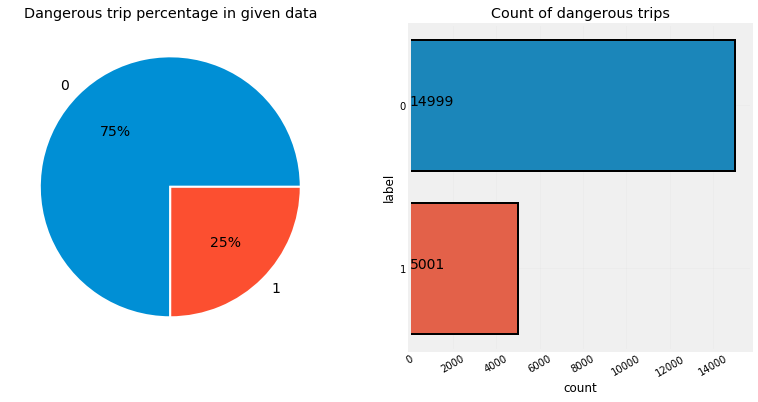

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
target_df["label"].value_counts().plot.pie(autopct  = "%1.0f%%",
                                           fontsize = 14,
                                           wedgeprops = {"linewidth": 2,
                                                         "edgecolor": "w"}
                                          )                     
plt.title("Dangerous trip percentage in given data")
plt.ylabel("")
plt.subplot(122)
ax = sns.countplot(y = target_df["label"], linewidth = 2, 
                   edgecolor = "k"*target_df["label"].nunique())
for i,j in enumerate(target_df["label"].value_counts().values): 
    ax.text(.1, i, j, fontsize=14, color="k")
    
plt.title("Count of dangerous trips")
plt.xticks(rotation=30)
plt.grid(True, alpha=.1)
plt.show()

The positive class, 1 - in this case, is at 25%.

#### Machine Learning Phase
##### 1. Basic model

- In this first step, I will use only the basic statistic of the given sensor to perform the prediction.
- First, let's simply plot the heatmap of the correlation of the features.

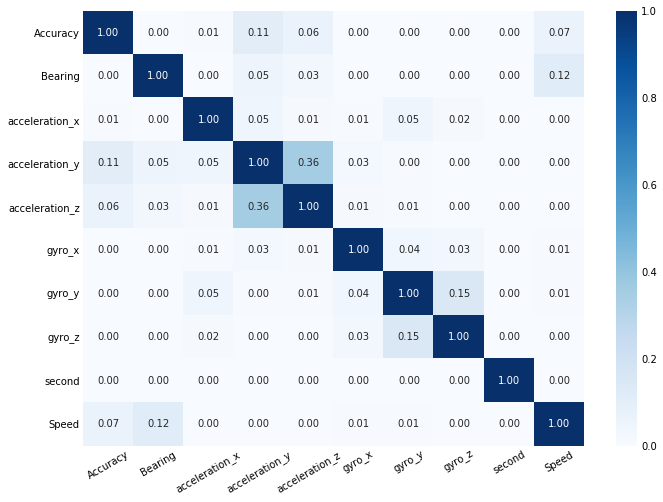

In [9]:
f, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(data_df.drop('bookingID', axis=1, inplace=False).corr().abs(), 
            vmin=0, vmax=1, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.xticks(rotation=30) 
plt.yticks(rotation=0) 
plt.show();

- I will use several distributions: min, max, mean, skewness, standard deviation, variance etc, of each sensor data.
- Data points such as Accuracy, Bearing will use less computation than the sensor data (i.e. min, max, median, p75).
- Second will use only count and maximum values.

In [10]:
def percentile(n: float):
    """
    Function to compute the percentile based on given n, this will use in `agg()` method in pandas
    @Args:
      n (float): the percentile to compute (i.e. 0.5 for median)
      
    Return:
      the percentile value
    """
    def percentile_(x):
        return x.quantile(n)
    
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_


def mean_abs_dev():
    """
    Function to compute the mean absolute deviation, which is the average distance between
      each data point and the mean. This helps to understand about the variability in the data.
    This should be 
    @Args:
      None
      
    Return:
      MAD value
    """
    def _mean_abs_dev(x):
        return x.mad()
    
    _mean_abs_dev.__name__ = 'mean_abs_dev'
    return _mean_abs_dev



In [11]:
sensor_data_df = \
data_df.groupby('bookingID').agg({'acceleration_x': [np.min, np.max, np.mean, 
                                                     np.median, np.var, np.std,
                                                     scipy.stats.skew, scipy.stats.kurtosis,
                                                     mean_abs_dev(), percentile(.25), percentile(.75)
                                                    ],
                                  'acceleration_y': [np.min, np.max, np.mean, 
                                                     np.median, np.var, np.std, 
                                                     scipy.stats.skew, scipy.stats.kurtosis,
                                                     mean_abs_dev(), percentile(.25), percentile(.75)
                                                    ],
                                  'acceleration_z': [np.min, np.max, np.mean, 
                                                     np.median, np.var, np.std, 
                                                     scipy.stats.skew, scipy.stats.kurtosis,
                                                     mean_abs_dev(), percentile(.25), percentile(.75)
                                                    ],
                                  'gyro_x': [np.min, np.max, np.mean, 
                                             np.median, np.var, np.std,
                                             scipy.stats.skew, scipy.stats.kurtosis,
                                             mean_abs_dev(), percentile(.25), percentile(.75)
                                            ],
                                  'gyro_y': [np.min, np.max, np.mean, 
                                             np.median, np.var, np.std, 
                                             scipy.stats.skew, scipy.stats.kurtosis,
                                             mean_abs_dev(), percentile(.25), percentile(.75)
                                            ],
                                  'gyro_z': [np.min, np.max, np.mean, 
                                             np.median, np.var, np.std, 
                                             scipy.stats.skew, scipy.stats.kurtosis,
                                             mean_abs_dev(), percentile(.25), percentile(.75)
                                            ],
                                  'Speed': [np.min, np.max, np.mean, 
                                            np.median, np.var, np.std, 
                                            scipy.stats.skew, scipy.stats.kurtosis,
                                            mean_abs_dev(), percentile(.25), percentile(.75)
                                           ]
                                 })
display(sensor_data_df.head(5))

acceleration_x                                               \
                    amin   amax    mean  median    var    std    skew   
bookingID                                                               
0                -4.6923 4.7826 -0.7113 -0.7253 0.8612 0.9280  0.3622   
1                -5.3530 3.8133 -0.5254 -0.5631 0.5538 0.7442  0.5246   
2                -2.9713 1.9561  0.3068  0.4334 0.5724 0.7566 -0.7394   
4                -2.8665 2.0196 -0.3651 -0.3812 0.2780 0.5272 -0.0319   
6                -4.3528 5.5930  0.4906  0.4765 0.6827 0.8263  0.3431   

                                                            acceleration_y  \
          kurtosis mean_abs_dev percentile_25 percentile_75           amin   
bookingID                                                                    
0           3.3140       0.6554       -1.1851       -0.2994       -12.7647   
1           9.0311       0.4714       -0.8411       -0.2294         6.6234   
2           1.1788       0.5920       -0.1987        0.8248         7.9418   
4           4.4099       0.3431       -0.5665       -0.1489       -18.8478   
6           5.9575       0.5378        0.1449        0.7626         6.4693   

                                                                               \
             amax    mean  median    var    std    skew kurtosis mean_abs_dev   
bookingID                                                                       
0         -6.1199 -9.6138 -9.6221 0.4095 0.6399  0.1686   3.9453       0.4384   
1         12.5362  9.5321  9.5380 0.2851 0.5339 -0.0668   3.4013       0.3772   
2         13.3337  9.8432  9.8141 0.2557 0.5057  1.6707  13.6517       0.2806   
4         -7.0650 -9.4064 -9.3650 0.3576 0.5980 -5.0200  69.5780       0.3378   
6         13.2499  9.5380  9.5627 0.3809 0.6172  0.0958   4.2665       0.4406   

                                      acceleration_z                         \
          percentile_25 percentile_75           amin   amax    mean  median   
bookingID                                                                     
0               -9.9039       -9.3444        -6.2518 2.3189 -1.6197 -1.6077   
1                9.2772        9.7968        -5.3555 1.4813 -2.1990 -2.1758   
2                9.6932        9.9614        -3.2826 2.3129  0.1393  0.3663   
4               -9.6037       -9.1785        -9.3749 0.2964 -2.6136 -2.6087   
6                9.1844        9.8764        -2.1405 7.9777  2.3551  2.3368   

                                                                     \
             var    std    skew kurtosis mean_abs_dev percentile_25   
bookingID                                                             
0         1.3025 1.1413 -0.1563   1.2489       0.8311       -2.2504   
1         0.7298 0.8543  0.0315   1.9065       0.6003       -2.5832   
2         1.0404 1.0200 -0.8523   0.8393       0.7856       -0.3891   
4         0.6077 0.7795 -0.3945   5.4700       0.5719       -3.0425   
6         0.8877 0.9422  0.2059   3.0135       0.6519        1.9394   

                         gyro_x                                              \
          percentile_75    amin   amax    mean  median    var    std   skew   
bookingID                                                                     
0               -1.0337 -0.3925 0.4384  0.0033  0.0026 0.0043 0.0660 0.1315   
1               -1.8192 -0.1254 0.1265 -0.0025 -0.0015 0.0008 0.0277 0.0664   
2                0.7745 -0.1552 0.2822  0.0065  0.0012 0.0029 0.0539 1.4238   
4               -2.2178 -0.4205 0.4387 -0.0229 -0.0228 0.0018 0.0423 0.7230   
6                2.7414 -0.2536 0.3622  0.0039  0.0006 0.0030 0.0552 0.7104   

                                                             gyro_y         \
          kurtosis mean_abs_dev percentile_25 percentile_75    amin   amax   
bookingID                                                                    
0           4.5502       0.0456       -0.0273        0.0332 -0.6099 0.4697   
1   

In [12]:
cols = {'acceleration_x_amin': 'min_acc_x', 'acceleration_x_amax': 'max_acc_x',
        'acceleration_x_mean': 'mean_acc_x', 'acceleration_x_median': 'p50_acc_x',
        'acceleration_x_var': 'var_acc_x', 'acceleration_x_std': 'std_acc_x',
        'acceleration_x_skew': 'skew_acc_x', 'acceleration_x_kurtosis': 'kurt_acc_x',
        'acceleration_x_mean_abs_dev': 'mad_acc_x', 'acceleration_x_percentile_25': 'p25_acc_x',
        'acceleration_x_percentile_75': 'p75_acc_x',
        
        'acceleration_y_amin': 'min_acc_y', 'acceleration_y_amax': 'max_acc_y',
        'acceleration_y_mean': 'mean_acc_y', 'acceleration_y_median': 'p50_acc_y',
        'acceleration_y_var': 'var_acc_y', 'acceleration_y_std': 'std_acc_y',
        'acceleration_y_skew': 'skew_acc_y', 'acceleration_y_kurtosis': 'kurt_acc_y',
        'acceleration_y_mean_abs_dev': 'mad_acc_y', 'acceleration_y_percentile_25': 'p25_acc_y',
        'acceleration_y_percentile_75': 'p75_acc_y',
        
        'acceleration_z_amin': 'min_acc_z', 'acceleration_z_amax': 'max_acc_z',
        'acceleration_z_mean': 'mean_acc_z', 'acceleration_z_median': 'p50_acc_z',
        'acceleration_z_var': 'var_acc_z', 'acceleration_z_std': 'std_acc_z',
        'acceleration_z_skew': 'skew_acc_z', 'acceleration_z_kurtosis': 'kurt_acc_z',
        'acceleration_z_mean_abs_dev': 'mad_acc_z', 'acceleration_z_percentile_25': 'p25_acc_z',
        'acceleration_z_percentile_75': 'p75_acc_z',
        
        'gyro_x_amin': 'min_gyro_x', 'gyro_x_amax': 'max_gyro_x',
        'gyro_x_mean': 'mean_gyro_x', 'gyro_x_median': 'p50_gyro_x',
        'gyro_x_var': 'var_gyro_x', 'gyro_x_std': 'std_gyro_x',
        'gyro_x_skew': 'skew_gyro_x', 'gyro_x_kurtosis': 'kurt_gyro_x',
        'gyro_x_mean_abs_dev': 'mad_gyro_x', 'gyro_x_percentile_25': 'p25_gyro_x',
        'gyro_x_percentile_75': 'p75_gyro_x',
        
        'gyro_y_amin': 'min_gyro_y', 'gyro_y_amax': 'max_gyro_y',
        'gyro_y_mean': 'mean_gyro_y', 'gyro_y_median': 'p50_gyro_y',
        'gyro_y_var': 'var_gyro_y', 'gyro_y_std': 'std_gyro_y',
        'gyro_y_skew': 'skew_gyro_y', 'gyro_y_kurtosis': 'kurt_gyro_y',
        'gyro_y_mean_abs_dev': 'mad_gyro_y', 'gyro_y_percentile_25': 'p25_gyro_y',
        'gyro_y_percentile_75': 'p75_gyro_y',
        
        'gyro_z_amin': 'min_gyro_z', 'gyro_z_amax': 'max_gyro_z',
        'gyro_z_mean': 'mean_gyro_z', 'gyro_z_median': 'p50_gyro_z',
        'gyro_z_var': 'var_gyro_z', 'gyro_z_std': 'std_gyro_z',
        'gyro_z_skew': 'skew_gyro_z', 'gyro_z_kurtosis': 'kurt_gyro_z',
        'gyro_z_mean_abs_dev': 'mad_gyro_z', 'gyro_z_percentile_25': 'p25_gyro_z',
        'gyro_z_percentile_75': 'p75_gyro_z',
        
        'Speed_amin': 'min_Speed', 'Speed_amax': 'max_Speed',
        'Speed_mean': 'mean_Speed', 'Speed_median': 'p50_Speed',
        'Speed_var': 'var_Speed', 'Speed_std': 'std_Speed',
        'Speed_skew': 'skew_Speed', 'Speed_kurtosis': 'kurt_Speed',
        'Speed_mean_abs_dev': 'mad_Speed', 'Speed_percentile_25': 'p25_Speed',
        'Speed_percentile_75': 'p75_Speed'
        
       }
       

In [13]:
sensor_data_df.columns = sensor_data_df.columns.map('_'.join).to_series().map(cols)
sensor_data_df.reset_index(drop=False, inplace=True)
display(sensor_data_df.head(5))

,bookingID,min_acc_x,max_acc_x,mean_acc_x,p50_acc_x,var_acc_x,std_acc_x,skew_acc_x,kurt_acc_x,mad_acc_x,p25_acc_x,p75_acc_x,min_acc_y,max_acc_y,mean_acc_y,p50_acc_y,var_acc_y,std_acc_y,skew_acc_y,kurt_acc_y,mad_acc_y,p25_acc_y,p75_acc_y,min_acc_z,max_acc_z,mean_acc_z,p50_acc_z,var_acc_z,std_acc_z,skew_acc_z,kurt_acc_z,mad_acc_z,p25_acc_z,p75_acc_z,min_gyro_x,max_gyro_x,mean_gyro_x,p50_gyro_x,var_gyro_x,std_gyro_x,skew_gyro_x,kurt_gyro_x,mad_gyro_x,p25_gyro_x,p75_gyro_x,min_gyro_y,max_gyro_y,mean_gyro_y,p50_gyro_y,var_gyro_y,std_gyro_y,skew_gyro_y,kurt_gyro_y,mad_gyro_y,p25_gyro_y,p75_gyro_y,min_gyro_z,max_gyro_z,mean_gyro_z,p50_gyro_z,var_gyro_z,std_gyro_z,skew_gyro_z,kurt_gyro_z,mad_gyro_z,p25_gyro_z,p75_gyro_z,min_Speed,max_Speed,mean_Speed,p50_Speed,var_Speed,std_Speed,skew_Speed,kurt_Speed,mad_Speed,p25_Speed,p75_Speed
0,0,-4.6923,4.7826,-0.7113,-0.7253,0.8612,0.9280,0.3622,3.3140,0.6554,-1.1851,-0.2994,-12.7647,-6.1199,-9.6138,-9.6221,0.4095,0.6399,0.1686,3.9453,0.4384,-9.9039,-9.3444,-6.2518,2.3189,-1.6197,-1.6077,1.3025,1.1413,-0.1563,1.2489,0.8311,-2.2504,-1.0337,-0.3925,0.4384,0.0033,0.0026,0.0043,0.0660,0.1315,4.5502,0.0456,-0.0273,0.0332,-0.6099,0.4697,-0.0061,-0.0022,0.0100,0.1002,-0.4730,6.1341,0.0652,-0.0462,0.0328,-0.7319,0.3728,-0.0042,-0.0035,0.0041,0.0637,-0.9916,20.7524,0.0411,-0.0299,0.0209,-1.0000,22.9461,8.9948,8.5034,51.8388,7.1999,0.1676,-1.4313,6.5121,1.4903,15.6455
1,1,-5.3530,3.8133,-0.5254,-0.5631,0.5538,0.7442,0.5246,9.0311,0.4714,-0.8411,-0.2294,6.6234,12.5362,9.5321,9.5380,0.2851,0.5339,-0.0668,3.4013,0.3772,9.2772,9.7968,-5.3555,1.4813,-2.1990,-2.1758,0.7298,0.8543,0.0315,1.9065,0.6003,-2.5832,-1.8192,-0.1254,0.1265,-0.0025,-0.0015,0.0008,0.0277,0.0664,2.6489,0.0192,-0.0157,0.0087,-0.6782,0.4708,-0.0075,-0.0035,0.0084,0.0917,-1.8500,13.7259,0.0523,-0.0339,0.0229,-0.1213,0.2351,0.0004,-0.0004,0.0011,0.0338,0.8118,5.6340,0.0228,-0.0149,0.0133,-1.0000,21.8821,7.8816,6.9046,49.8346,7.0594,0.3472,-1.2438,6.2239,0.0000,13.7479
2,2,-2.9713,1.9561,0.3068,0.4334,0.5724,0.7566,-0.7394,1.1788,0.5920,-0.1987,0.8248,7.9418,13.3337,9.8432,9.8141,0.2557,0.5057,1.6707,13.6517,0.2806,9.6932,9.9614,-3.2826,2.3129,0.1393,0.3663,1.0404,1.0200,-0.8523,0.8393,0.7856,-0.3891,0.7745,-0.1552,0.2822,0.0065,0.0012,0.0029,0.0539,1.4238,6.2999,0.0320,-0.0129,0.0161,-0.4620,0.4317,-0.0129,0.0010,0.0138,0.1173,-0.1857,3.3405,0.0746,-0.0445,0.0212,-0.1259,0.2559,0.0026,0.0018,0.0013,0.0362,1.5433,12.9625,0.0215,-0.0080,0.0134,0.0000,9.3605,3.1572,2.9988,8.3970,2.8978,0.4074,-1.0684,2.5171,0.0000,5.3000
3,4,-2.8665,2.0196,-0.3651,-0.3812,0.2780,0.5272,-0.0319,4.4099,0.3431,-0.5665,-0.1489,-18.8478,-7.0650,-9.4064,-9.3650,0.3576,0.5980,-5.0200,69.5780,0.3378,-9.6037,-9.1785,-9.3749,0.2964,-2.6136,-2.6087,0.6077,0.7795,-0.3945,5.4700,0.5719,-3.0425,-2.2178,-0.4205,0.4387,-0.0229,-0.0228,0.0018,0.0423,0.7230,26.5683,0.0242,-0.0364,-0.0085,-0.5065,0.6526,0.0232,0.0245,0.0127,0.1126,-0.1355,3.5782,0.0750,-0.0181,0.0732,-0.3482,0.5052,-0.0004,-0.0011,0.0043,0.0659,0.5470,7.1477,0.0453,-0.0329,0.0315,0.0000,19.7800,6.1510,3.3100,31.3141,5.5959,0.8722,-0.6382,4.7609,2.1900,10.2225
4,6,-4.3528,5.5930,0.4906,0.4765,0.6827,0.8263,0.3431,5.9575,0.5378,0.1449,0.7626,6.4693,13.2499,9.5380,9.5627,0.3809,0.6172,0.0958,4.2665,0.4406,9.1844,9.8764,-2.1405,7.9777,2.3551,2.3368,0.8877,0.9422,0.2059,3.0135,0.6519,1.9394,2.7414,-0.2536,0.3622,0.0039,0.0006,0.0030,0.0552,0.7104,5.8569,0.0373,-0.0220,0.0281,-0.6218,0.5321,0.0004,0.0037,0.0114,0.1068,-0.7834,9.6237,0.0573,-0.0207,0.0257,-0.3483,0.3645,0.0029,0.0029,0.0033,0.0574,-0.0344,6.9847,0.0358,-0.0151,0.0228,0.0000,16.3947,4.6289,1.9370,28.2476,5.3148,0.7237,-1.0012,4.7120,0.0000,9.2171


Now let's finish off with transforming the rest of the columns (second, Accuracy, Bearing).

- Accuracy of GPS should not be swinging much.
- Bearing will be dropped for this case of model building.
- Second will keep the count and max.

In [14]:
other_data_df = data_df.groupby('bookingID').\
agg({'Accuracy': [np.min, np.median, percentile(.75), np.max],
     'second': ['count', 'max']})
cols = {'Accuracy_amin': 'min_accuracy', 'Accuracy_amax': 'max_accuracy',
        'Accuracy_median': 'median_accuracy', 'Accuracy_percentile_75': 'p75_accuracy',
        'second_count': 'rec_cnt', 'second_max': 'max_sec'
       }
other_data_df.columns = other_data_df.columns.map('_'.join).to_series().map(cols)
other_data_df.reset_index(inplace=True)
other_data_df['max_sec'] = other_data_df['max_sec'] + 1  # add one as second starts from 0.
display(other_data_df.head(5))

,bookingID,min_accuracy,median_accuracy,p75_accuracy,max_accuracy,rec_cnt,max_sec
0,0,4.0000,8.0000,12.0000,48.0000,1004,1590.0000
1,1,3.0000,3.9000,4.0000,7.7090,851,1035.0000
2,2,3.0000,3.6340,4.0000,8.0000,195,826.0000
3,4,10.0000,10.0000,10.0000,10.0000,1094,1095.0000
4,6,3.0000,4.0040,4.9385,12.0000,1095,1095.0000


In [15]:
feature_df = pd.merge(sensor_data_df, other_data_df, how='left', on='bookingID')
display(feature_df.head(5))
print(feature_df.shape)

,bookingID,min_acc_x,max_acc_x,mean_acc_x,p50_acc_x,var_acc_x,std_acc_x,skew_acc_x,kurt_acc_x,mad_acc_x,p25_acc_x,p75_acc_x,min_acc_y,max_acc_y,mean_acc_y,p50_acc_y,var_acc_y,std_acc_y,skew_acc_y,kurt_acc_y,mad_acc_y,p25_acc_y,p75_acc_y,min_acc_z,max_acc_z,mean_acc_z,p50_acc_z,var_acc_z,std_acc_z,skew_acc_z,kurt_acc_z,mad_acc_z,p25_acc_z,p75_acc_z,min_gyro_x,max_gyro_x,mean_gyro_x,p50_gyro_x,var_gyro_x,std_gyro_x,skew_gyro_x,kurt_gyro_x,mad_gyro_x,p25_gyro_x,p75_gyro_x,min_gyro_y,max_gyro_y,mean_gyro_y,p50_gyro_y,var_gyro_y,std_gyro_y,skew_gyro_y,kurt_gyro_y,mad_gyro_y,p25_gyro_y,p75_gyro_y,min_gyro_z,max_gyro_z,mean_gyro_z,p50_gyro_z,var_gyro_z,std_gyro_z,skew_gyro_z,kurt_gyro_z,mad_gyro_z,p25_gyro_z,p75_gyro_z,min_Speed,max_Speed,mean_Speed,p50_Speed,var_Speed,std_Speed,skew_Speed,kurt_Speed,mad_Speed,p25_Speed,p75_Speed,min_accuracy,median_accuracy,p75_accuracy,max_accuracy,rec_cnt,max_sec
0,0,-4.6923,4.7826,-0.7113,-0.7253,0.8612,0.9280,0.3622,3.3140,0.6554,-1.1851,-0.2994,-12.7647,-6.1199,-9.6138,-9.6221,0.4095,0.6399,0.1686,3.9453,0.4384,-9.9039,-9.3444,-6.2518,2.3189,-1.6197,-1.6077,1.3025,1.1413,-0.1563,1.2489,0.8311,-2.2504,-1.0337,-0.3925,0.4384,0.0033,0.0026,0.0043,0.0660,0.1315,4.5502,0.0456,-0.0273,0.0332,-0.6099,0.4697,-0.0061,-0.0022,0.0100,0.1002,-0.4730,6.1341,0.0652,-0.0462,0.0328,-0.7319,0.3728,-0.0042,-0.0035,0.0041,0.0637,-0.9916,20.7524,0.0411,-0.0299,0.0209,-1.0000,22.9461,8.9948,8.5034,51.8388,7.1999,0.1676,-1.4313,6.5121,1.4903,15.6455,4.0000,8.0000,12.0000,48.0000,1004,1590.0000
1,1,-5.3530,3.8133,-0.5254,-0.5631,0.5538,0.7442,0.5246,9.0311,0.4714,-0.8411,-0.2294,6.6234,12.5362,9.5321,9.5380,0.2851,0.5339,-0.0668,3.4013,0.3772,9.2772,9.7968,-5.3555,1.4813,-2.1990,-2.1758,0.7298,0.8543,0.0315,1.9065,0.6003,-2.5832,-1.8192,-0.1254,0.1265,-0.0025,-0.0015,0.0008,0.0277,0.0664,2.6489,0.0192,-0.0157,0.0087,-0.6782,0.4708,-0.0075,-0.0035,0.0084,0.0917,-1.8500,13.7259,0.0523,-0.0339,0.0229,-0.1213,0.2351,0.0004,-0.0004,0.0011,0.0338,0.8118,5.6340,0.0228,-0.0149,0.0133,-1.0000,21.8821,7.8816,6.9046,49.8346,7.0594,0.3472,-1.2438,6.2239,0.0000,13.7479,3.0000,3.9000,4.0000,7.7090,851,1035.0000
2,2,-2.9713,1.9561,0.3068,0.4334,0.5724,0.7566,-0.7394,1.1788,0.5920,-0.1987,0.8248,7.9418,13.3337,9.8432,9.8141,0.2557,0.5057,1.6707,13.6517,0.2806,9.6932,9.9614,-3.2826,2.3129,0.1393,0.3663,1.0404,1.0200,-0.8523,0.8393,0.7856,-0.3891,0.7745,-0.1552,0.2822,0.0065,0.0012,0.0029,0.0539,1.4238,6.2999,0.0320,-0.0129,0.0161,-0.4620,0.4317,-0.0129,0.0010,0.0138,0.1173,-0.1857,3.3405,0.0746,-0.0445,0.0212,-0.1259,0.2559,0.0026,0.0018,0.0013,0.0362,1.5433,12.9625,0.0215,-0.0080,0.0134,0.0000,9.3605,3.1572,2.9988,8.3970,2.8978,0.4074,-1.0684,2.5171,0.0000,5.3000,3.0000,3.6340,4.0000,8.0000,195,826.0000
3,4,-2.8665,2.0196,-0.3651,-0.3812,0.2780,0.5272,-0.0319,4.4099,0.3431,-0.5665,-0.1489,-18.8478,-7.0650,-9.4064,-9.3650,0.3576,0.5980,-5.0200,69.5780,0.3378,-9.6037,-9.1785,-9.3749,0.2964,-2.6136,-2.6087,0.6077,0.7795,-0.3945,5.4700,0.5719,-3.0425,-2.2178,-0.4205,0.4387,-0.0229,-0.0228,0.0018,0.0423,0.7230,26.5683,0.0242,-0.0364,-0.0085,-0.5065,0.6526,0.0232,0.0245,0.0127,0.1126,-0.1355,3.5782,0.0750,-0.0181,0.0732,-0.3482,0.5052,-0.0004,-0.0011,0.0043,0.0659,0.5470,7.1477,0.0453,-0.0329,0.0315,0.0000,19.7800,6.1510,3.3100,31.3141,5.5959,0.8722,-0.6382,4.7609,2.1900,10.2225,10.0000,10.0000,10.0000,10.0000,1094,1095.0000
4,6,-4.3528,5.5930,0.4906,0.4765,0.6827,0.8263,0.3431,5.9575,0.5378,0.1449,0.7626,6.4693,13.2499,9.5380,9.5627,0.3809,0.6172,0.0958,4.2665,0.4406,9.1844,9.8764,-2.1405,7.9777,2.3551,2.3368,0.8877,0.9422,0.2059,3.0135,0.6519,1.9394,2.7414,-0.2536,0.3622,0.0039,0.0006,0.0030,0.0552,0.7104,5.8569,0.0373,-0.0220,0.0281,-0.6218,0.5321,0.0004,0.0037,0.0114,0.1068,-0.7834,9.6237,0.0573,-0.0207,0.0257,-0.3483,0.3645,0.0029,0.0029,0.0033,0.0574,-0.0344,6.9847,0.0358,-0.0151,0.0228,0.0000,16.3947,4.6289,1.9370,28.2476,5.3148,0.7237,-1.0012,4.7120,0.0000,9.2171,3.0000,4.0040,4.9385,12.0000,1095,1095.0000


(20000, 84)


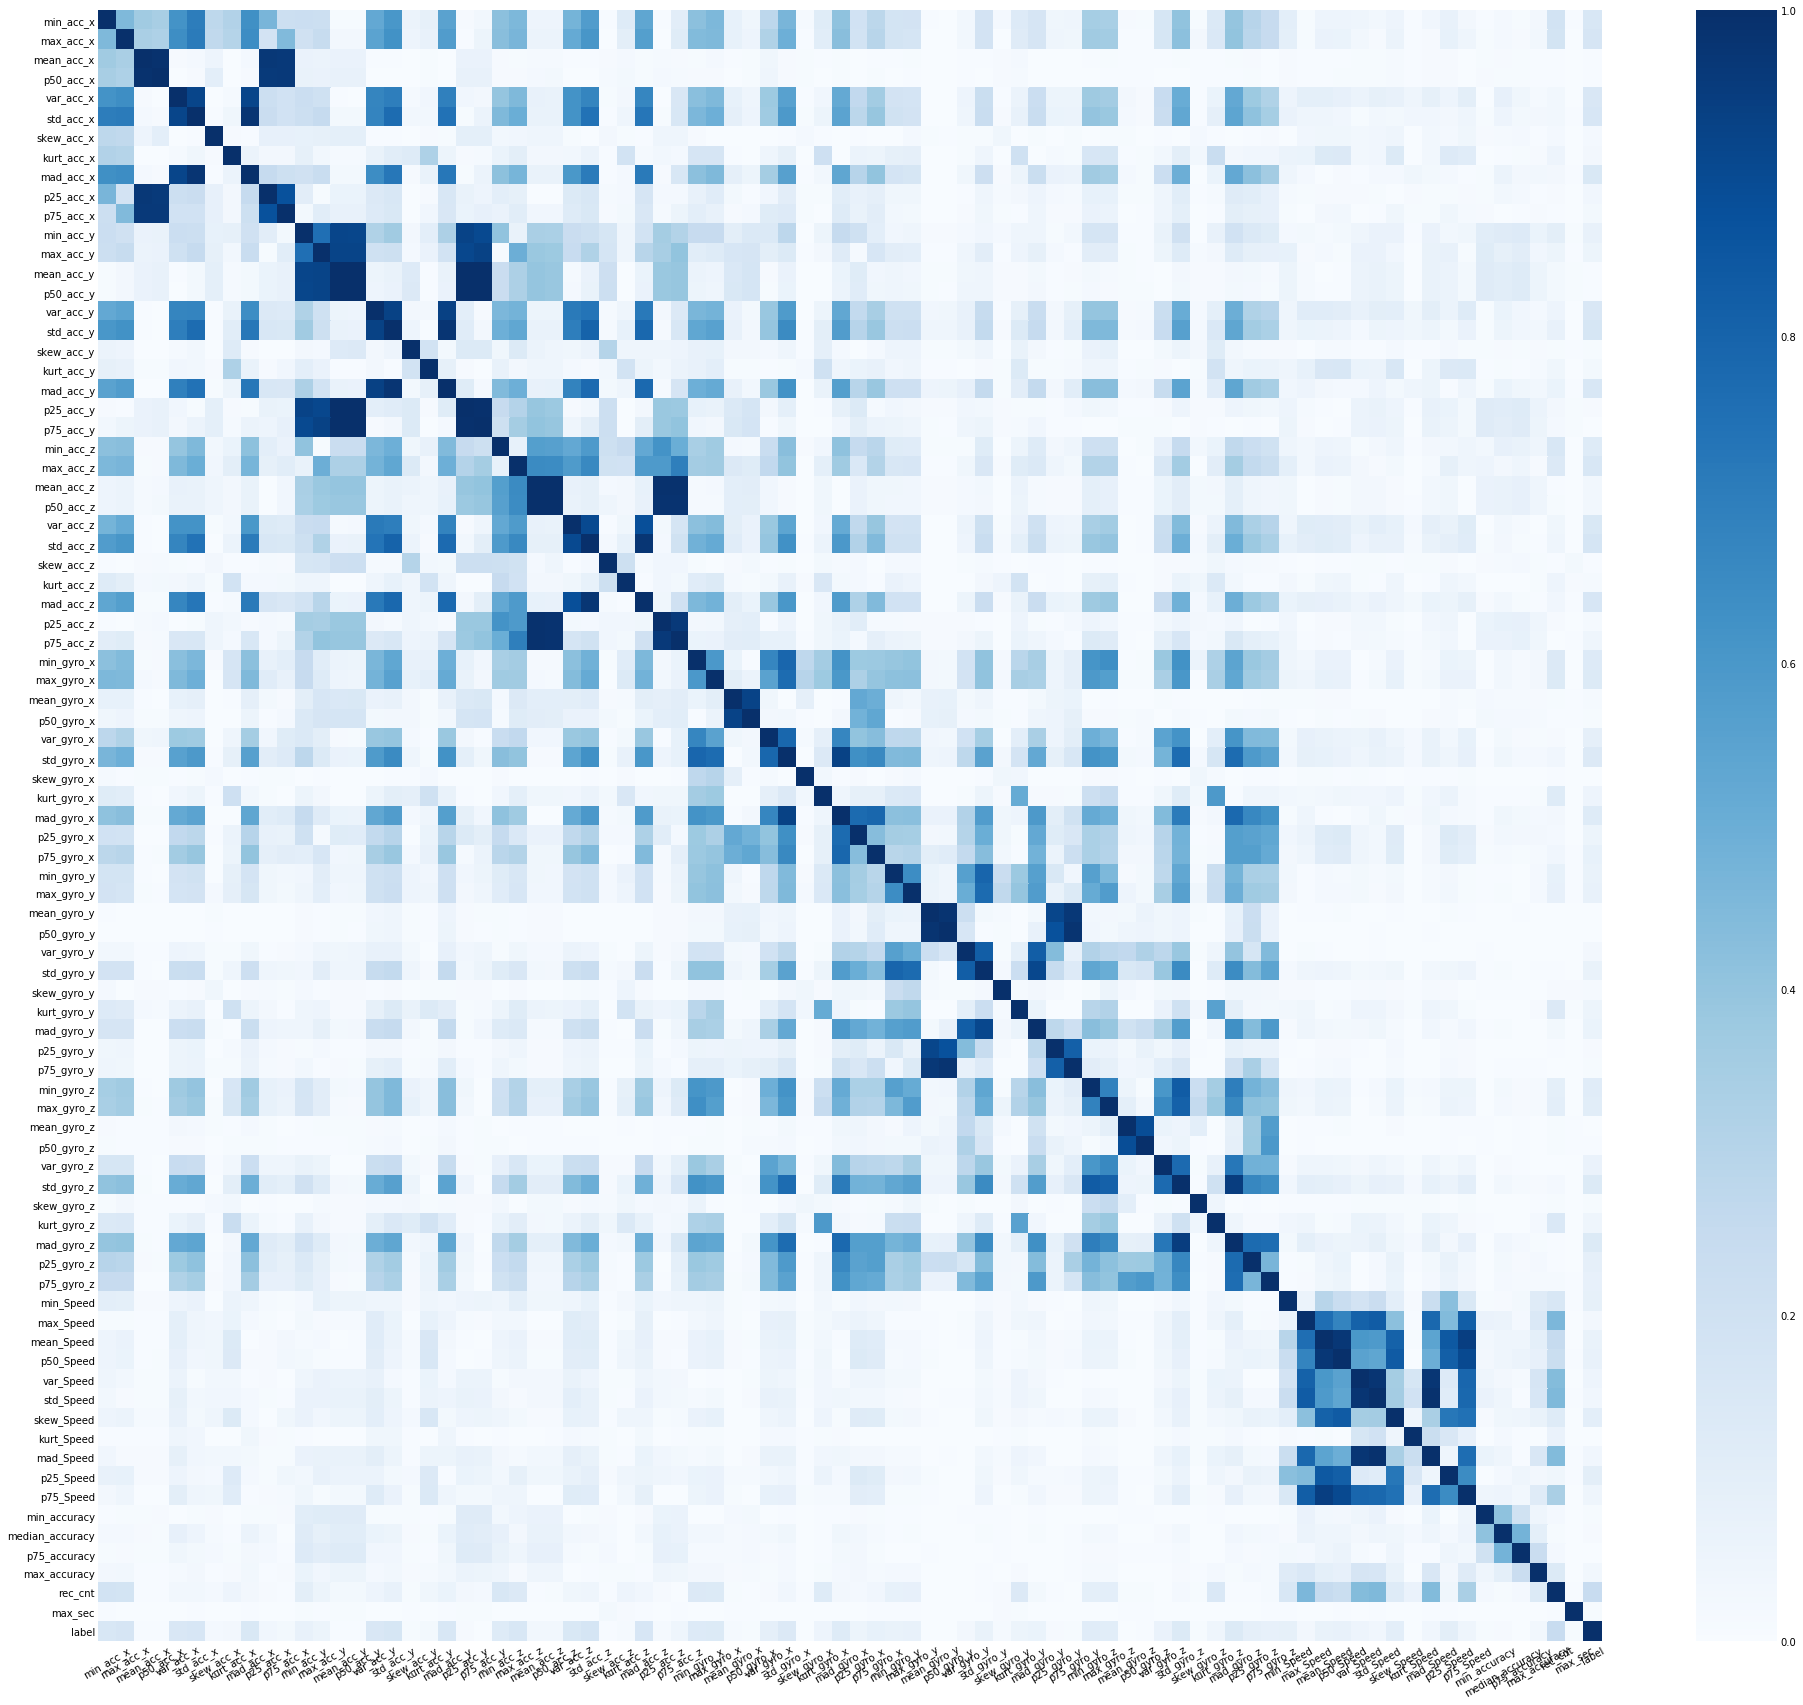

In [16]:
f, axes = plt.subplots(1, 1, figsize=(30, 30))
_tmp = pd.merge(feature_df, target_df, how='left', on='bookingID')
sns.heatmap(_tmp.drop('bookingID', axis=1, inplace=False).corr().abs(), 
            vmin=0, vmax=1, annot=False, cmap='Blues', cbar=True)
plt.xticks(rotation=30) 
plt.yticks(rotation=0) 
plt.show();

We have one data set with all the features including **bookingID** and label data set. I will separate this onto train and test data set.

In [17]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# Machine learning related
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, scorer
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve


In [18]:
def prediction_evaluation (algorithm, X_train, X_test, y_train, y_test, 
                           predictor_cols, cf = 'features'):
    """
     Function to predict and evaluate the provided algorithm by using Plotly library 
       to visualize the confusion matrix, ROC curve as well as provided the feature importances.
     @Args:
       algorithm: the model algorithm object
       X_train: the predictor features of the training pandas data frame
       X_test: the predictor features of the testing pandas data frame
       y_train: the target variable of the training pandas data frame
       y_test: the target variable of the testing pandas data frame
       cf: toggle the mode on how to get the informaiton out from the model, 
         the input only accepts 2 possible list of values. 
         LOV - 'coefficients': specifically for logistic regression
             - 'features': specifically for tree-based model
     Return:
        prediction and probabilities
    """
    if cf not in ['features', 'coefficients']:
        # Exception case - return None
        print("ERROR: Mode Toggle (cf parameters) is not in LOV. Please recheck")
        return None, None
    
    algorithm.fit(X_train, y_train)
    y_pred = algorithm.predict(X_test)
    y_prob = algorithm.predict_proba(X_test)
    algorithm_name = str(algorithm).split('(', 1)[0] 
    
    if cf == 'coefficients':
        coeff = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == 'features':
        coeff = pd.DataFrame(algorithm.feature_importances_)
        
    col_df = pd.DataFrame(predictor_cols)
    coef_smry = pd.merge(coeff, col_df, left_index=True, right_index=True, how='left')
    coef_smry.columns = ['coefficients', 'features']
    coef_smry = coef_smry.sort_values(by='coefficients', ascending=False)
    conf_matrix = confusion_matrix(y_test, y_pred)
    # compute metric
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    accuracy_  = ((tp + tn) / (tp + tn + fp + fn))
    precision_ = (tp / (tp + fp))
    recall_    = (tp / (tp + fn))
    f1_score_  = f1_score(y_test, y_pred)
    model_roc_auc = roc_auc_score(y_test, y_pred)
    
    # Print report
    print(algorithm)
    print("\nClassification report: \n", classification_report(y_test, y_pred))
    print("\nAccuracy Score: ", np.round(accuracy_score(y_test, y_pred), 4))
    print("F1 Score: ", np.round(f1_score_, 4))
    print("Area Under Curve: ", np.round(model_roc_auc, 4), "\n")
    
    # Trace 1: plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ['Safe', 'Danger'],
                        y = ['Safe', 'Danger'],
                        showscale = False,
                        colorscale = 'Picnic',
                        name = "Confusion Matrix"
                       )
    
    # Trace 2: plot model metrics
    show_metrics = pd.DataFrame(data=[[accuracy_ , precision_, recall_, f1_score_]])
    show_metrics = show_metrics.T
    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x=(show_metrics[0].values), 
                    y=['Accuracy', 'Precision', 'Recall', 'F1 score'], 
                    text=np.round_(show_metrics[0].values,4),
                    name='',
                    textposition='auto',
                    orientation='h', 
                    opacity=0.8,
                    marker=dict(color=colors,
                                line=dict(color='#000000',
                                          width=1.5)
                               )
                   )

    # Trace 3: plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    trace3 = go.Scatter(x = fpr,
                        y = tpr,
                        name = "ROC: " + str(model_roc_auc),
                        line = dict(color = 'rgb(22, 96, 197)',
                                    width = 2
                                   )
                       )
    trace4 = go.Scatter(x = [0, 1],
                        y = [0, 1],
                        line = dict(color = 'rgb(205, 12, 24)',
                                     width = 1.5,
                                     dash = 'dot'
                                   )
                       )
    
    # Trace 4: plot precision-recall curve
    __precision, __recall, t = precision_recall_curve(y_test, y_prob[:, 1])
    trace5 = go.Scatter(x=__recall, 
                        y=__precision,
                        name="Precision %s" % str(__precision),
                        line=dict(color=('lightcoral'),
                                  width = 2), 
                        fill='tozeroy'
                       )
    
    # Trace 5: plot coeffs
    trace6 = go.Bar(x = coef_smry['features'],
                    y = coef_smry['coefficients'],
                    name = "coefficients",
                    marker = dict(color = coef_smry['coefficients'],
                                  colorscale = 'Picnic',
                                  line = dict(width = .6, color = 'black')
                                 )
                   )
    
    # subplots
    fig = tls.make_subplots(rows = 3, cols = 2, 
                            specs = [[{}, {}], 
                                     [{}, {}],
                                     [{'colspan': 2}, None]],
                            subplot_titles = ('Confusion Matrix',
                                              'Metrics',
                                              'Receiver Operating Characteristics (ROC)',
                                              'Precision - Recall curve',
                                              'Feature Importances'
                                             )
                           )
    
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 1)
    fig.append_trace(trace5, 2, 2)
    fig.append_trace(trace6, 3, 1)
    
    fig['layout'].update(showlegend = False, title = "Model Performance of {}".format(algorithm_name),
                         autosize = False,
                         height = 1000,
                         width = 800,
                         plot_bgcolor = 'rgba(240, 240, 240, 0.95)',
                         paper_bgcolor = 'rgba(240, 240, 240, 0.95)',
                         margin = dict(b = 195)
                        )
    fig['layout']['xaxis1'].update(dict(title="Prediction"))
    fig['layout']['yaxis1'].update(dict(title="Actual"))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig['layout']['xaxis3'].update(dict(title="False Positive Rate"))
    fig['layout']['yaxis3'].update(dict(title='True Positive Rate'))
    fig["layout"]["xaxis4"].update(dict(title="recall"), 
                                   range=[0, 1.05])
    fig["layout"]["yaxis4"].update(dict(title="precision"), 
                                   range=[0, 1.05])
    fig['layout']['xaxis5'].update(dict(showgrid=True,
                                        tickfont=dict(size = 10),
                                        tickangle=90
                                       )
                                  )
    fig.layout.titlefont.size = 14
    py.iplot(fig)
    return y_pred, y_prob

In [19]:
feature_df.sort_values(by='bookingID', ascending=True, inplace=True)
target_df.sort_values(by='bookingID', ascending=True, inplace=True)
target_df.reset_index(drop=True, inplace=True)
display(target_df.head(5))

,bookingID,label
0,0,0
1,1,1
2,2,1
3,4,1
4,6,0


Remove bookingID

In [20]:
booking_id = feature_df['bookingID']
X = feature_df.drop('bookingID', axis=1, inplace=False)
y = target_df['label']

In [21]:
def my_fold(algorithm, n_splits=5):
    k_fold_ = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    _auroc_score = []
    _accuracy_score = []
    _f1_score = []
    i = 1
    for train_idx, test_idx in k_fold_.split(X, y):
        print('%d of total %d folds' % (i, k_fold_.n_splits))
        _booking_id_train, _booking_id_test = booking_id.iloc[train_idx], booking_id.iloc[test_idx]
        X_train, X_test = X.loc[train_idx, :], X.loc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        algorithm.fit(X_train, y_train)
        auroc_score_ = roc_auc_score(y_test, algorithm.predict(X_test))
        accuracy_score_ = accuracy_score(y_test, algorithm.predict(X_test))
        f1_score_ = f1_score(y_test, algorithm.predict(X_test))
        print('%s has AUC score: %.4f, accuracy score: %.4f, f1-score: %.4f' % \
              (str(algorithm).split('(', 1)[0], auroc_score_, accuracy_score_, f1_score_ ))
        _auroc_score.append(auroc_score_)
        _accuracy_score.append(accuracy_score_)
        _f1_score.append(f1_score_)
        i+=1
        
    print('AUROC score: %.4f with std of %.4f' % (np.mean(_auroc_score), np.std(_auroc_score)))
    return algorithm

rf_clf = my_fold(RandomForestClassifier(random_state=SEED))

1 of total 5 folds
RandomForestClassifier has AUC score: 0.5737, accuracy score: 0.7616, f1-score: 0.2933
2 of total 5 folds
RandomForestClassifier has AUC score: 0.5745, accuracy score: 0.7628, f1-score: 0.2944
3 of total 5 folds
RandomForestClassifier has AUC score: 0.5720, accuracy score: 0.7605, f1-score: 0.2893
4 of total 5 folds
RandomForestClassifier has AUC score: 0.5720, accuracy score: 0.7585, f1-score: 0.2918
5 of total 5 folds
RandomForestClassifier has AUC score: 0.5703, accuracy score: 0.7649, f1-score: 0.2780
AUROC score: 0.5725 with std of 0.0015


In [22]:
xgb_clf = my_fold(xgboost.XGBClassifier(random_state=SEED))

1 of total 5 folds
XGBClassifier has AUC score: 0.5947, accuracy score: 0.7836, f1-score: 0.3338
2 of total 5 folds
XGBClassifier has AUC score: 0.5833, accuracy score: 0.7755, f1-score: 0.3071
3 of total 5 folds
XGBClassifier has AUC score: 0.5883, accuracy score: 0.7835, f1-score: 0.3138
4 of total 5 folds
XGBClassifier has AUC score: 0.5860, accuracy score: 0.7785, f1-score: 0.3121
5 of total 5 folds
XGBClassifier has AUC score: 0.5792, accuracy score: 0.7792, f1-score: 0.2885
AUROC score: 0.5863 with std of 0.0052


In [23]:
tree_clf = my_fold(tree.DecisionTreeClassifier(random_state=SEED))

1 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5781, accuracy score: 0.6723, f1-score: 0.3730
2 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5822, accuracy score: 0.6803, f1-score: 0.3764
3 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5645, accuracy score: 0.6703, f1-score: 0.3486
4 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5830, accuracy score: 0.6790, f1-score: 0.3785
5 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5776, accuracy score: 0.6804, f1-score: 0.3680
AUROC score: 0.5771 with std of 0.0066


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [25]:
_ = prediction_evaluation(tree_clf, X_train, X_test, y_train, y_test, 
                      predictor_cols=X_train.columns, cf = 'features')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      3714
           1       0.37      0.40      0.38      1286

   micro avg       0.67      0.67      0.67      5000
   macro avg       0.58      0.58      0.58      5000
weighted avg       0.68      0.67      0.68      5000


Accuracy Score:  0.6728
F1 Score:  0.3831
Area Under Curve:  0.582 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5           -      ]



In [26]:
_ = prediction_evaluation(rf_clf, X_train, X_test, y_train, y_test, 
                      predictor_cols=X_train.columns, cf = 'features')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.96      0.86      3714
           1       0.63      0.20      0.31      1286

   micro avg       0.76      0.76      0.76      5000
   macro avg       0.70      0.58      0.58      5000
weighted avg       0.74      0.76      0.72      5000


Accuracy Score:  0.7644
F1 Score:  0.3071
Area Under Curve:  0.5809 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5           -      ]



In [27]:
_ = prediction_evaluation(xgb_clf, X_train, X_test, y_train, y_test, 
                          predictor_cols=X_train.columns, cf = 'features')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.97      0.87      3714
           1       0.73      0.20      0.31      1286

   micro avg       0.78      0.78      0.78      5000
   macro avg       0.75      0.59      0.59      5000
weighted avg       0.77      0.78      0.72      5000


Accuracy Score:  0.775
F1 Score:  0.3119
Area Under Curve:  0.5865 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5           -      ]



##### 2. Convolutional Neural Network (CNN or ConvNet)

In this first round, I will use __recurrence plots__ as pre-processing step for time series so we can apply ConvNet.

In [28]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.python.keras.layers import MaxPooling2D, BatchNormalization
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import Callback
import sklearn
from skimage.transform import resize

keras.backend.set_session(tf.Session(config=tf.ConfigProto(device_count={"CPU": 8})))

Using TensorFlow backend.


Recurrence plots are a visualization tool for multivariate time-series. They are based on exploring the characteristic recurrent behaviour of a time-series. 

Let  $q(t)∈Rd$  be a multi-variate time-series. It's recurrence plot is defined as
$RPi,j=θ(ϵ−||q(i)−q(j)||)$
 
where  ϵ  is a threshold and  θ  is the heaviside function.

In [29]:
def recurrence_plot(s, eps=None, steps=None):
    # Reference from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sklearn.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    return d


In [30]:
full_df = pd.merge(data_df, target_df, how='left', on='bookingID')

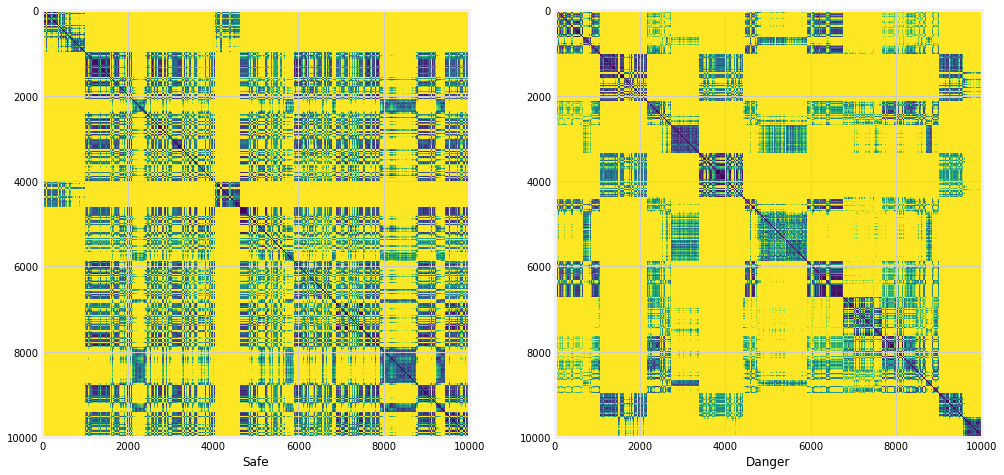

In [31]:
cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
        'gyro_x', 'gyro_y', 'gyro_z', 'Speed']

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(recurrence_plot(full_df.loc[full_df.label == 0, cols].head(10000).values, steps=100))
ax.set_xlabel('Safe')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(recurrence_plot(full_df.loc[full_df.label == 1, cols].head(10000).values, steps=100))
ax.set_xlabel('Danger')
plt.show();

The images look different for both classes (safe and danger trip). Hence, we can use the image classification tools to distinguish between the recurrence plot of different activities. 

To be able to do this, we need to convert all time series to recurrence plots and scale them to equal sizes.

In [32]:
# initialize values
X = np.zeros((20000, 32, 32))
y = np.zeros(20000)
c = 0

# Loop process all sensor data as defined above to recurrence images
for i in data_df.bookingID.unique():
    _img = recurrence_plot(data_df.loc[data_df.bookingID == i, cols].values, steps=100)
    _img = resize(_img, (32, 32), mode='constant')
    X[c, :, :] = _img
    y[c] = target_df.loc[target_df.bookingID == i, 'label'].unique()[0]
    c+=1
    if c % 500 == 0:
        print('Processing %d records' % c)
    
print('Processing Completed!!')

Processing 500 records
Processing 1000 records
Processing 1500 records
Processing 2000 records
Processing 2500 records
Processing 3000 records
Processing 3500 records
Processing 4000 records
Processing 4500 records
Processing 5000 records
Processing 5500 records
Processing 6000 records
Processing 6500 records
Processing 7000 records
Processing 7500 records
Processing 8000 records
Processing 8500 records
Processing 9000 records
Processing 9500 records
Processing 10000 records
Processing 10500 records
Processing 11000 records
Processing 11500 records
Processing 12000 records
Processing 12500 records
Processing 13000 records
Processing 13500 records
Processing 14000 records
Processing 14500 records
Processing 15000 records
Processing 15500 records
Processing 16000 records
Processing 16500 records
Processing 17000 records
Processing 17500 records
Processing 18000 records
Processing 18500 records
Processing 19000 records
Processing 19500 records
Processing 20000 records
Processing Completed

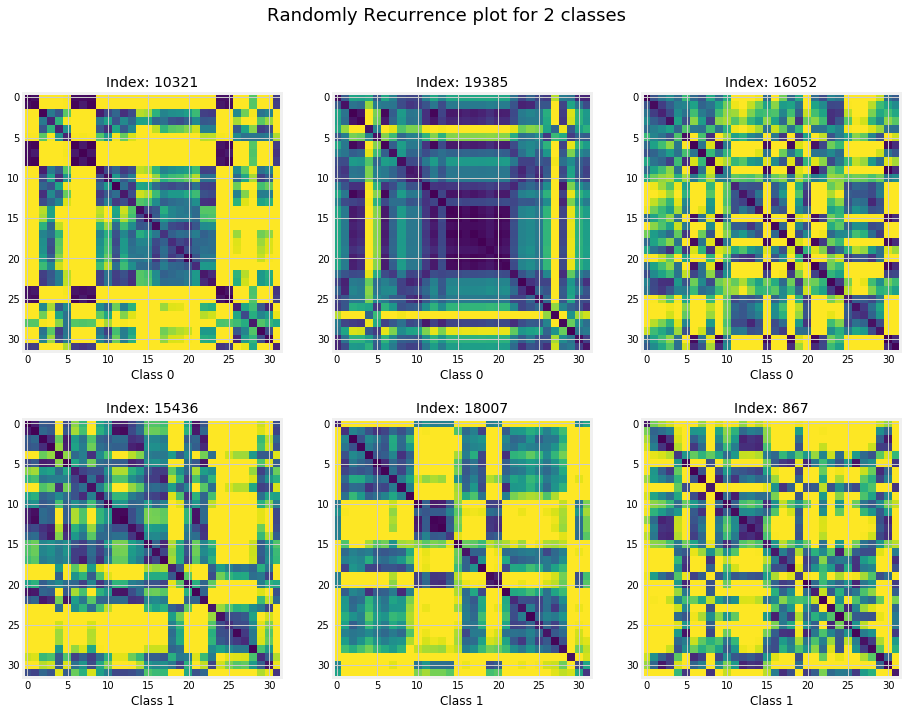

In [33]:
fig = plt.figure(figsize=(14, 11))
height, width = (2, 3)
i_ = 0
np.random.seed(SEED)
for j in np.random.choice(np.where(y==0)[0], size=3, replace=False):
    i_+=1 
    ax = fig.add_subplot(height, width, i_)
    ax.imshow(X[j, :, :])
    ax.set_title('Index: %d' % j, size=14)
    ax.set_xlabel('Class %d' % y[j], size=12)

for j in np.random.choice(np.where(y==1)[0], size=3, replace=False):
    i_+=1 
    ax = fig.add_subplot(height, width, i_)
    ax.imshow(X[j, :, :])
    ax.set_title('Index: %d' % j, size=14)
    ax.set_xlabel('Class %d' % y[j], size=12)

fig.suptitle('Randomly Recurrence plot for 2 classes', size=18)
plt.show();

In [34]:
tf.random.set_random_seed(SEED)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=(32, 32, 1)))
model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Conv2D(64, (3, 3)))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [35]:
X = X.reshape(X.shape[0], 32, 32, 1)
X = X.astype('float32')
X /= np.amax(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
class auc_loss_history(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.auc = None
        self.auc_val = None
        self.losses = None
        self.val_losses = None
        
    def on_train_begin(self, logs={}):
        self.auc = []
        self.auc_val = []
        self.losses = []
        self.val_losses = []
        
    def _auc_score(self, predictions, targets):
        """
        Function to compute Compute AUC ROC Score
        """
        return roc_auc_score(predictions, targets)
        
    def on_train_end(self, logs={}):
        return
    
    def on_epoch_begin(self, epoch, logs={}):
        return
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        auc = self._auc_score(self.y, self.model.predict(self.x))
        auc_val = self._auc_score(self.y_val, self.model.predict(self.x_val))
        self.auc.append(auc)
        self.auc_val.append(auc_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % \
              (str(round(auc, 4)),str(round(auc_val, 4))),end=100*' '+'\n')
        return
    
    def on_batch_begin(self, batch, logs={}):
        return
    
    def on_batch_end(self, batch, logs={}):
        return

    
# define the callbacks 
auc_loss_hist = auc_loss_history(training_data=(X_train, y_train),
                                 validation_data=(X_test, y_test))
checkpointer = ModelCheckpoint(filepath='../model/safety_cnn2d_model.hdf5', verbose=1, 
                               monitor='val_loss',save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min')
my_callbacks = [auc_loss_hist, checkpointer, early_stop]

# fit the model
hist = model.fit(X_train, y_train,
                 batch_size=16,
                 epochs=200,
                 verbose=2,
                 validation_data=(X_test, y_test),
                 callbacks=my_callbacks
                )

Train on 16000 samples, validate on 4000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
roc-auc: 0.6052 - roc-auc_val: 0.5779                                                                                                    

Epoch 00001: val_loss improved from inf to 0.57020, saving model to ../model/safety_cnn2d_model.hdf5
 - 69s - loss: 0.5692 - acc: 0.7511 - val_loss: 0.5702 - val_acc: 0.7412
Epoch 2/200
roc-auc: 0.6265 - roc-auc_val: 0.5827                                                                                                    

Epoch 00002: val_loss did not improve from 0.57020
 - 67s - loss: 0.5564 - acc: 0.7520 - val_loss: 0.5772 - val_acc: 0.7412
Epoch 3/200
roc-auc: 0.59 - roc-auc_val: 0.5519                                                                                                    

Epoch 00003: val_loss did not improve from 0.57020
 - 67s - loss: 0.5554 - acc: 0.7515 - val_loss: 0.5714 - val_acc: 0.7412
Epoch 4/200
roc-auc: 0.6079 - 

Epoch 29/200
roc-auc: 0.7455 - roc-auc_val: 0.5761                                                                                                    

Epoch 00029: val_loss did not improve from 0.55403
 - 68s - loss: 0.5102 - acc: 0.7688 - val_loss: 0.5890 - val_acc: 0.7427
Epoch 30/200
roc-auc: 0.7519 - roc-auc_val: 0.5721                                                                                                    

Epoch 00030: val_loss did not improve from 0.55403
 - 68s - loss: 0.4972 - acc: 0.7747 - val_loss: 0.5908 - val_acc: 0.7460
Epoch 31/200
roc-auc: 0.7784 - roc-auc_val: 0.5775                                                                                                    

Epoch 00031: val_loss did not improve from 0.55403
 - 68s - loss: 0.4933 - acc: 0.7742 - val_loss: 0.5858 - val_acc: 0.7452
Epoch 32/200
roc-auc: 0.7793 - roc-auc_val: 0.5774                                                                                                    

Epoch 00032: val_los

The best epoch is at 17, we will load that weight to make the prediction.

In [37]:
model.load_weights('../model/safety_cnn2d_model.hdf5')

In [38]:
y_pred = model.predict_classes(X_test)
print('Sample of predictions: %s' % y_pred[0: 5])
print('Sample of true test label: %s' % y_test[0: 5])

Sample of predictions: [[0]
 [0]
 [0]
 [0]
 [0]]
Sample of true test label: [0. 0. 1. 0. 0.]


In [39]:
def plot_performance_report(y_true: np.ndarray, y_pred:np.ndarray,
                            history: keras.callbacks.History, 
                            callbacks_history: keras.callbacks.History, 
                            num_classes: int=2):
    """
    Function to plot the performance of the neural network model
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    _acc = history.history['acc']
    _val_acc = history.history['val_acc']
    _loss = history.history['loss']
    _val_loss = history.history['val_loss']
    _auc = callbacks_history.auc
    _val_auc = callbacks_history.auc_val
    _epo = list(range(len(_acc)))
    _epo = [x+1 for x in _epo]  # add 1 to simulate the real epoch numbers
    target_names = ['Safe', 'Danger']
    _acc_score = accuracy_score(y_true, y_pred)
    
    # Trace 1: plot confusion matrix
    trace1 = go.Heatmap(z=conf_matrix,
                        x=target_names,
                        y=target_names,
                        showscale=False,
                        colorscale='Viridis',
                        name="Confusion Matrix",
                        opacity=.8
                       )
    
    trace2 = go.Scatter(x=_epo,
                        y=_acc,
                        name="Train Acc",
                        line=dict(color='blue',
                                  width=2
                                 )
                       )
    
    trace3 = go.Scatter(x=_epo,
                        y=_val_acc,
                        name="Val Acc",
                        line=dict(color='black',
                                  width=2,
                                  dash='dot'
                                 )
                       )
    
    trace4 = go.Scatter(x=_epo, 
                        y=_loss,
                        name='Train Loss',
                        line=dict(color='blue',
                                  width=2)
                       )
    
    trace5 = go.Scatter(x=_epo,
                        y=_val_loss,
                        name='Val Loss',
                        line=dict(color='black',
                                  width=2,
                                  dash='dot')
                       )
    
    trace6 = go.Scatter(x=_epo, 
                        y=_auc,
                        name='Train AUC',
                        line=dict(color='blue',
                                  width=2)
                       )
    
    trace7 = go.Scatter(x=_epo,
                        y=_val_auc,
                        name='Val AUC',
                        line=dict(color='black',
                                  width=2,
                                  dash='dot')
                       )
    
    # create subplots
    fig = tls.make_subplots(rows=2, cols=2, 
                            specs=[[{}, {}], 
                                   [{}, {}]],
                            subplot_titles=('<b>Confusion Matrix</b> of Testing set',
                                            '<b>Accuracy</b> During Training',
                                            '<b>Loss</b>',
                                            '<b>AUC score</b>'
                                           )
                           )
    
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 1, 2)
    fig.append_trace(trace4, 2, 1)
    fig.append_trace(trace5, 2, 1)
    fig.append_trace(trace6, 2, 2)
    fig.append_trace(trace7, 2, 2)
    
    fig['layout'].update(showlegend = False, 
                         title = "CNN Model Performance (Accuracy on Testing set: %s)" % _acc_score,
                         autosize = False,
                         height = 700,
                         width = 800,
                         plot_bgcolor = 'rgba(240, 240, 240, 0.95)',
                         paper_bgcolor = 'rgba(240, 240, 240, 0.95)'
                        )
    fig['layout']['xaxis1'].update(dict(title="Prediction"),
                                   tickangle=45,
                                   showgrid=False)
    fig['layout']['yaxis1'].update(dict(title="Actual"))
    fig['layout']['xaxis2'].update(dict(title="# Epoch"),
                                   showgrid=True)
    fig['layout']['yaxis2'].update(dict(title="Accuracy Score"),
                                   showgrid=False)
    fig['layout']['xaxis3'].update(dict(title="# Epoch"),
                                   showgrid=False)
    fig['layout']['yaxis3'].update(dict(title="Loss value"),
                                   zeroline=True,
                                   showgrid=False
                                  )
    fig['layout']['xaxis4'].update(dict(title="# Epoch"),
                                   showgrid=False)
    fig['layout']['yaxis4'].update(dict(title="AUC Score"),
                                   zeroline=True,
                                   showgrid=False
                                  )
    
    fig.layout.titlefont.size = 20
    py.iplot(fig)
    

plot_performance_report(y_test, y_pred, hist, auc_loss_hist, 2)


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



It seems like the AUC score is around 0.6 for test set. The accuracy is around 0.74-0.75 before dropping, showing the sign of overfitting to the training data set.

##### 3. Transform the data before modeling

- As per EDA notebook, we can use `low-pass` filter to filter noise from the sensor data.
- We can translate the $\frac{m}{s^2}$ to actual $g$ by dividing them by the gravity.

In [40]:
G_FORCE = 9.8

In [41]:
data_df['acceleration_x_g'] = data_df['acceleration_x'] / G_FORCE
data_df['acceleration_y_g'] = data_df['acceleration_y'] / G_FORCE
data_df['acceleration_z_g'] = data_df['acceleration_z'] / G_FORCE

Compute the total magnitude from the acceleration data

In [42]:
data_df['total_magnitude'] = (data_df[['acceleration_x_g', 
                                       'acceleration_y_g', 
                                       'acceleration_z_g']]**2).sum(axis=1)**0.5
display(data_df.head(5))

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acceleration_x_g,acceleration_y_g,acceleration_z_g,total_magnitude
0,0,12.0000,143.2983,0.8181,-9.9415,-2.0150,-0.0162,-0.0940,0.0707,0.0000,3.4430,0.0835,-1.0144,-0.2056,1.0384
1,0,8.0000,143.2983,0.5464,-9.8356,-2.0389,-0.0471,-0.0789,0.0432,1.0000,0.2285,0.0558,-1.0036,-0.2081,1.0265
2,0,8.0000,143.2983,-1.7062,-9.2708,-1.2094,-0.0290,-0.0327,0.0154,2.0000,0.2285,-0.1741,-0.9460,-0.1234,0.9698
3,0,8.0000,143.2983,-1.4167,-9.5480,-1.8610,-0.0224,0.0050,-0.0258,3.0000,0.2285,-0.1446,-0.9743,-0.1899,1.0031
4,0,8.0000,143.2983,-0.5981,-9.8535,-1.3786,-0.0143,-0.0462,0.0219,4.0000,0.2285,-0.0610,-1.0055,-0.1407,1.0171


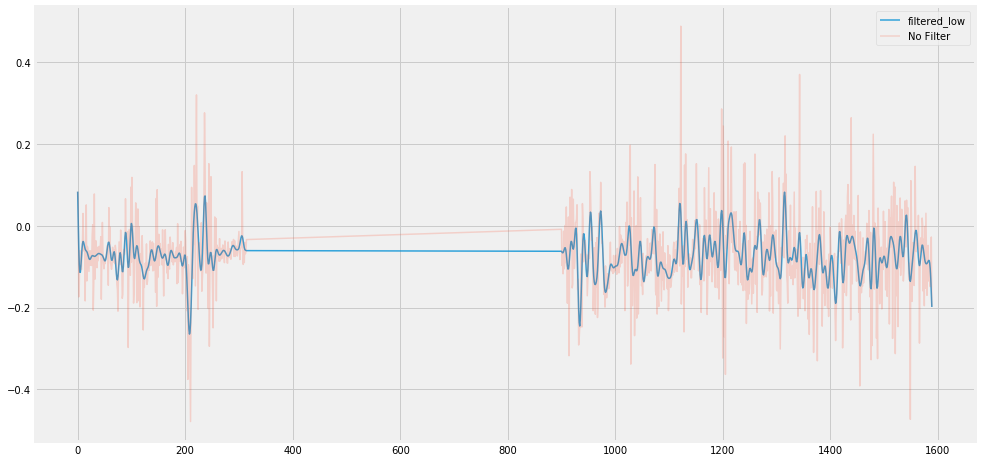

In [43]:
def filter_sensor_data(ax: pd.Series, 
                       n: int=5, fc: int=50, fs: int=500, mode: str='lowpass'):
    """
    Function to apply the filter to digital sensor data
    @Args:
      ax (pd.Series):
      n (int): the order of the filter
      fc (int): cut off frequency of the signal
      fs (int): sampling frequency
      mode (str): mode of filter to be used (i.e. lowpass, highpass)
      
    Return:
      series containing the after filtered data
        A scalar or length-2 sequence giving the critical frequencies. 
        For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) 
        that of the passband (the “-3 dB point”).

        For digital filters, Wn are in the same units as fs. By default, 
        fs is 2 half-cycles/sample, so these are normalized from 0 to 1, 
        where 1 is the Nyquist frequency. (Wn is thus in half-cycles / sample.)

        For analog filters, Wn is an angular frequency (e.g. rad/s).
    """
    from scipy import signal
    w = fc / (fs / 2)
    b, a = signal.butter(N=n, Wn=w, btype=mode)
    output = signal.filtfilt(b, a, ax)
    return output

# Demonstrate the low filter vs. original data
plt.figure(figsize=(15, 8))
plt.plot(data_df.loc[data_df.bookingID == 0, 'second'], 
         filter_sensor_data(data_df.loc[data_df.bookingID == 0, 'acceleration_x_g'],
                            n=5, fc=50, fs=500),
         label='filtered_low',
         lw=1.5, alpha=.8)
plt.plot(data_df.loc[data_df.bookingID == 0, 'second'], 
         data_df.loc[data_df.bookingID == 0, 'acceleration_x_g'],
         label='No Filter',
         lw=1.5, alpha=.2)
plt.legend()
plt.show();

In [44]:
key_ = []
ax_all = []
ay_all = []
az_all = []
gx_all = []
gy_all = []
gz_all = []
for i in data_df.bookingID.unique():
    _ax = filter_sensor_data(data_df.loc[data_df.bookingID == i, 'acceleration_x_g'])
    _ay = filter_sensor_data(data_df.loc[data_df.bookingID == i, 'acceleration_y_g'])
    _az = filter_sensor_data(data_df.loc[data_df.bookingID == i, 'acceleration_z_g'])
    _gx = filter_sensor_data(data_df.loc[data_df.bookingID == i, 'gyro_x'])
    _gy = filter_sensor_data(data_df.loc[data_df.bookingID == i, 'gyro_y'])
    _gz = filter_sensor_data(data_df.loc[data_df.bookingID == i, 'gyro_z'])
    key_.append(i)
    ax_all.append(_ax)
    ay_all.append(_ay)
    az_all.append(_az)
    gx_all.append(_gx)
    gy_all.append(_gy)
    gz_all.append(_gz)

Stack back to pandas data frame

In [45]:
full_ = pd.DataFrame()
for i in range(len(key_)):
    _tmp = pd.DataFrame({'bookingID': np.repeat(key_[i], len(ax_all[i]), axis=0),
                  'acc_x_transform': ax_all[i], 
                  'acc_y_transform': ay_all[i],
                  'acc_z_transform': az_all[i],
                  'gyro_x_transform': ax_all[i], 
                  'gyro_y_transform': ay_all[i],
                  'gyro_z_transform': az_all[i],
                 })
    full_ = pd.concat([full_, _tmp], axis=0)
    full_.reset_index(drop=True, inplace=True)

display(full_.head(5))
display(full_.tail(5))
print(full_.shape)

,bookingID,acc_x_transform,acc_y_transform,acc_z_transform,gyro_x_transform,gyro_y_transform,gyro_z_transform
0,0,0.0833,-1.0145,-0.2056,0.0833,-1.0145,-0.2056
1,0,0.0103,-0.9997,-0.1916,0.0103,-0.9997,-0.1916
2,0,-0.0515,-0.9876,-0.1784,-0.0515,-0.9876,-0.1784
3,0,-0.0940,-0.9804,-0.1668,-0.0940,-0.9804,-0.1668
4,0,-0.1140,-0.9786,-0.1571,-0.1140,-0.9786,-0.1571


,bookingID,acc_x_transform,acc_y_transform,acc_z_transform,gyro_x_transform,gyro_y_transform,gyro_z_transform
16135556,1709396983975,-0.0334,-0.9141,-0.4043,-0.0334,-0.9141,-0.4043
16135557,1709396983975,-0.0335,-0.9142,-0.4063,-0.0335,-0.9142,-0.4063
16135558,1709396983975,-0.0285,-0.9148,-0.4083,-0.0285,-0.9148,-0.4083
16135559,1709396983975,-0.0185,-0.9162,-0.4088,-0.0185,-0.9162,-0.4088
16135560,1709396983975,-0.0051,-0.9178,-0.4078,-0.0051,-0.9178,-0.4078


(16135561, 7)


In [46]:
full_['total_magnitude'] = (full_[['acc_x_transform', 
                                   'acc_y_transform', 
                                   'acc_z_transform']]**2).sum(axis=1)**0.5
display(full_.head(5))

,bookingID,acc_x_transform,acc_y_transform,acc_z_transform,gyro_x_transform,gyro_y_transform,gyro_z_transform,total_magnitude
0,0,0.0833,-1.0145,-0.2056,0.0833,-1.0145,-0.2056,1.0385
1,0,0.0103,-0.9997,-0.1916,0.0103,-0.9997,-0.1916,1.0179
2,0,-0.0515,-0.9876,-0.1784,-0.0515,-0.9876,-0.1784,1.0049
3,0,-0.0940,-0.9804,-0.1668,-0.0940,-0.9804,-0.1668,0.9989
4,0,-0.1140,-0.9786,-0.1571,-0.1140,-0.9786,-0.1571,0.9977


Use this data to construct features.

In [47]:
full_['second'] = data_df['second']
full_['Speed'] = data_df['Speed']
display(full_.head(3))

,bookingID,acc_x_transform,acc_y_transform,acc_z_transform,gyro_x_transform,gyro_y_transform,gyro_z_transform,total_magnitude,second,Speed
0,0,0.0833,-1.0145,-0.2056,0.0833,-1.0145,-0.2056,1.0385,0.0000,3.4430
1,0,0.0103,-0.9997,-0.1916,0.0103,-0.9997,-0.1916,1.0179,1.0000,0.2285
2,0,-0.0515,-0.9876,-0.1784,-0.0515,-0.9876,-0.1784,1.0049,2.0000,0.2285


In [48]:
other_data_df = full_.groupby('bookingID').\
agg({'second': ['count', 'max']})
cols = {'second_count': 'rec_cnt', 'second_max': 'max_sec'
       }
other_data_df.columns = other_data_df.columns.map('_'.join).to_series().map(cols)
other_data_df.reset_index(inplace=True)
other_data_df['max_sec'] = other_data_df['max_sec'] + 1  # add one as second starts from 0.
display(other_data_df.head(5))

,bookingID,rec_cnt,max_sec
0,0,1004,1590.0000
1,1,851,1035.0000
2,2,195,826.0000
3,4,1094,1095.0000
4,6,1095,1095.0000


In [49]:
sensor_data_df = \
full_.groupby('bookingID').agg({'acc_x_transform': [np.min, np.max, np.mean, 
                                                 np.median, np.var, np.std,
                                                 scipy.stats.skew, scipy.stats.kurtosis,
                                                 mean_abs_dev(), percentile(.25), percentile(.75)
                                                ],
                              'acc_y_transform': [np.min, np.max, np.mean, 
                                                 np.median, np.var, np.std, 
                                                 scipy.stats.skew, scipy.stats.kurtosis,
                                                 mean_abs_dev(), percentile(.25), percentile(.75)
                                                ],
                              'acc_z_transform': [np.min, np.max, np.mean, 
                                                 np.median, np.var, np.std, 
                                                 scipy.stats.skew, scipy.stats.kurtosis,
                                                 mean_abs_dev(), percentile(.25), percentile(.75)
                                                ],
                              'gyro_x_transform': [np.min, np.max, np.mean, 
                                         np.median, np.var, np.std,
                                         scipy.stats.skew, scipy.stats.kurtosis,
                                         mean_abs_dev(), percentile(.25), percentile(.75)
                                        ],
                              'gyro_y_transform': [np.min, np.max, np.mean, 
                                         np.median, np.var, np.std, 
                                         scipy.stats.skew, scipy.stats.kurtosis,
                                         mean_abs_dev(), percentile(.25), percentile(.75)
                                        ],
                              'gyro_z_transform': [np.min, np.max, np.mean, 
                                         np.median, np.var, np.std, 
                                         scipy.stats.skew, scipy.stats.kurtosis,
                                         mean_abs_dev(), percentile(.25), percentile(.75)
                                        ],
                              'Speed': [np.min, np.max, np.mean, 
                                        np.median, np.var, np.std, 
                                        scipy.stats.skew, scipy.stats.kurtosis,
                                        mean_abs_dev(), percentile(.25), percentile(.75)
                                       ]
                             })
display(sensor_data_df.head(5))

acc_x_transform                                               \
                     amin   amax    mean  median    var    std    skew   
bookingID                                                                
0                 -0.2650 0.0833 -0.0727 -0.0739 0.0021 0.0459  0.0055   
1                 -0.3884 0.2204 -0.0537 -0.0549 0.0035 0.0594  0.3936   
2                 -0.1246 0.1601  0.0314  0.0507 0.0034 0.0586 -0.6877   
4                 -0.2468 0.1541 -0.0373 -0.0391 0.0016 0.0399 -0.0672   
6                 -0.1102 0.3007  0.0501  0.0480 0.0030 0.0545  0.8515   

                                                            acc_y_transform  \
          kurtosis mean_abs_dev percentile_25 percentile_75            amin   
bookingID                                                                     
0           1.7639       0.0336       -0.0995       -0.0489         -1.0730   
1           7.0872       0.0386       -0.0803       -0.0306          0.8543   
2          -0.2605       0.0480       -0.0035        0.0733          0.9430   
4           4.8951       0.0265       -0.0533       -0.0218         -1.2744   
6           3.0027       0.0372        0.0254        0.0697          0.8697   

                                                                               \
             amax    mean  median    var    std    skew kurtosis mean_abs_dev   
bookingID                                                                       
0         -0.8540 -0.9809 -0.9828 0.0009 0.0299  0.3802   1.4060       0.0216   
1          1.0416  0.9728  0.9750 0.0007 0.0273 -0.4260   1.1404       0.0202   
2          1.0554  1.0045  1.0037 0.0003 0.0183 -0.4811   2.4172       0.0123   
4         -0.8653 -0.9599 -0.9569 0.0011 0.0328 -3.4061  26.9585       0.0197   
6          1.0974  0.9732  0.9743 0.0009 0.0304 -0.2075   1.9576       0.0216   

                                      acc_z_transform                          \
          percentile_25 percentile_75            amin    amax    mean  median   
bookingID                                                                       
0               -0.9963       -0.9665         -0.3550  0.0383 -0.1652 -0.1636   
1                0.9587        0.9874         -0.4134 -0.0221 -0.2242 -0.2222   
2                0.9974        1.0114         -0.1684  0.2058  0.0156  0.0152   
4               -0.9689       -0.9454         -0.4606 -0.0736 -0.2667 -0.2647   
6                0.9603        0.9894          0.0326  0.5270  0.2405  0.2411   

                                                                     \
             var    std    skew kurtosis mean_abs_dev percentile_25   
bookingID                                                             
0         0.0041 0.0643  0.0064   0.0886       0.0500       -0.2063   
1         0.0036 0.0599 -0.0362   0.8029       0.0438       -0.2551   
2         0.0044 0.0666 -0.1838   0.3614       0.0509       -0.0201   
4         0.0039 0.0625  0.1570   0.2677       0.0481       -0.3057   
6         0.0043 0.0658  0.2549   1.9809       0.0465        0.2067   

                        gyro_x_transform                                       \
          percentile_75             amin   amax    mean  median    var    std   
bookingID                                                                       
0               -0.1238          -0.2650 0.0833 -0.0727 -0.0739 0.0021 0.0459   
1               -0.1885          -0.3884 0.2204 -0.0537 -0.0549 0.0035 0.0594   
2                0.0562          -0.1246 0.1601  0.0314  0.0507 0.0034 0.0586   
4               -0.2358          -0.2468 0.1541 -0.0373 -0.0391 0.0016 0.0399   
6                0.2710          -0.1102 0.3007  0.0501  0.0480 0.0030 0.0545   

                                                                     \
             skew kurtosis mean_abs_dev percentile_25 percentile_75   
bookingID                                                             
0          0.0055   1.7639       0.0336       -0.0995  

In [50]:
cols = {'acc_x_transform_amin': 'min_acc_x', 'acc_x_transform_amax': 'max_acc_x',
        'acc_x_transform_mean': 'mean_acc_x', 'acc_x_transform_median': 'p50_acc_x',
        'acc_x_transform_var': 'var_acc_x', 'acc_x_transform_std': 'std_acc_x',
        'acc_x_transform_skew': 'skew_acc_x', 'acc_x_transform_kurtosis': 'kurt_acc_x',
        'acc_x_transform_mean_abs_dev': 'mad_acc_x', 'acc_x_transform_percentile_25': 'p25_acc_x',
        'acc_x_transform_percentile_75': 'p75_acc_x',
        
        'acc_y_transform_amin': 'min_acc_y', 'acc_y_transform_amax': 'max_acc_y',
        'acc_y_transform_mean': 'mean_acc_y', 'acc_y_transform_median': 'p50_acc_y',
        'acc_y_transform_var': 'var_acc_y', 'acc_y_transform_std': 'std_acc_y',
        'acc_y_transform_skew': 'skew_acc_y', 'acc_y_transform_kurtosis': 'kurt_acc_y',
        'acc_y_transform_mean_abs_dev': 'mad_acc_y', 'acc_y_transform_percentile_25': 'p25_acc_y',
        'acc_y_transform_percentile_75': 'p75_acc_y',
        
        'acc_z_transform_amin': 'min_acc_z', 'acc_z_transform_amax': 'max_acc_z',
        'acc_z_transform_mean': 'mean_acc_z', 'acc_z_transform_median': 'p50_acc_z',
        'acc_z_transform_var': 'var_acc_z', 'acc_z_transform_std': 'std_acc_z',
        'acc_z_transform_skew': 'skew_acc_z', 'acc_z_transform_kurtosis': 'kurt_acc_z',
        'acc_z_transform_mean_abs_dev': 'mad_acc_z', 'acc_z_transform_percentile_25': 'p25_acc_z',
        'acc_z_transform_percentile_75': 'p75_acc_z',
        
        'gyro_x_transform_amin': 'min_gyro_x', 'gyro_x_transform_amax': 'max_gyro_x',
        'gyro_x_transform_mean': 'mean_gyro_x', 'gyro_x_transform_median': 'p50_gyro_x',
        'gyro_x_transform_var': 'var_gyro_x', 'gyro_x_transform_std': 'std_gyro_x',
        'gyro_x_transform_skew': 'skew_gyro_x', 'gyro_x_transform_kurtosis': 'kurt_gyro_x',
        'gyro_x_transform_mean_abs_dev': 'mad_gyro_x', 'gyro_x_transform_percentile_25': 'p25_gyro_x',
        'gyro_x_transform_percentile_75': 'p75_gyro_x',
        
        'gyro_y_transform_amin': 'min_gyro_y', 'gyro_y_transform_amax': 'max_gyro_y',
        'gyro_y_transform_mean': 'mean_gyro_y', 'gyro_y_transform_median': 'p50_gyro_y',
        'gyro_y_transform_var': 'var_gyro_y', 'gyro_y_transform_std': 'std_gyro_y',
        'gyro_y_transform_skew': 'skew_gyro_y', 'gyro_y_transform_kurtosis': 'kurt_gyro_y',
        'gyro_y_transform_mean_abs_dev': 'mad_gyro_y', 'gyro_y_transform_percentile_25': 'p25_gyro_y',
        'gyro_y_transform_percentile_75': 'p75_gyro_y',
        
        'gyro_z_transform_amin': 'min_gyro_z', 'gyro_z_transform_amax': 'max_gyro_z',
        'gyro_z_transform_mean': 'mean_gyro_z', 'gyro_z_transform_median': 'p50_gyro_z',
        'gyro_z_transform_var': 'var_gyro_z', 'gyro_z_transform_std': 'std_gyro_z',
        'gyro_z_transform_skew': 'skew_gyro_z', 'gyro_z_transform_kurtosis': 'kurt_gyro_z',
        'gyro_z_transform_mean_abs_dev': 'mad_gyro_z', 'gyro_z_transform_percentile_25': 'p25_gyro_z',
        'gyro_z_transform_percentile_75': 'p75_gyro_z',
        
        'Speed_amin': 'min_Speed', 'Speed_amax': 'max_Speed',
        'Speed_mean': 'mean_Speed', 'Speed_median': 'p50_Speed',
        'Speed_var': 'var_Speed', 'Speed_std': 'std_Speed',
        'Speed_skew': 'skew_Speed', 'Speed_kurtosis': 'kurt_Speed',
        'Speed_mean_abs_dev': 'mad_Speed', 'Speed_percentile_25': 'p25_Speed',
        'Speed_percentile_75': 'p75_Speed'
        
       }
       
sensor_data_df.columns = sensor_data_df.columns.map('_'.join).to_series().map(cols)
sensor_data_df.reset_index(drop=False, inplace=True)
display(sensor_data_df.head(5))

,bookingID,min_acc_x,max_acc_x,mean_acc_x,p50_acc_x,var_acc_x,std_acc_x,skew_acc_x,kurt_acc_x,mad_acc_x,p25_acc_x,p75_acc_x,min_acc_y,max_acc_y,mean_acc_y,p50_acc_y,var_acc_y,std_acc_y,skew_acc_y,kurt_acc_y,mad_acc_y,p25_acc_y,p75_acc_y,min_acc_z,max_acc_z,mean_acc_z,p50_acc_z,var_acc_z,std_acc_z,skew_acc_z,kurt_acc_z,mad_acc_z,p25_acc_z,p75_acc_z,min_gyro_x,max_gyro_x,mean_gyro_x,p50_gyro_x,var_gyro_x,std_gyro_x,skew_gyro_x,kurt_gyro_x,mad_gyro_x,p25_gyro_x,p75_gyro_x,min_gyro_y,max_gyro_y,mean_gyro_y,p50_gyro_y,var_gyro_y,std_gyro_y,skew_gyro_y,kurt_gyro_y,mad_gyro_y,p25_gyro_y,p75_gyro_y,min_gyro_z,max_gyro_z,mean_gyro_z,p50_gyro_z,var_gyro_z,std_gyro_z,skew_gyro_z,kurt_gyro_z,mad_gyro_z,p25_gyro_z,p75_gyro_z,min_Speed,max_Speed,mean_Speed,p50_Speed,var_Speed,std_Speed,skew_Speed,kurt_Speed,mad_Speed,p25_Speed,p75_Speed
0,0,-0.2650,0.0833,-0.0727,-0.0739,0.0021,0.0459,0.0055,1.7639,0.0336,-0.0995,-0.0489,-1.0730,-0.8540,-0.9809,-0.9828,0.0009,0.0299,0.3802,1.4060,0.0216,-0.9963,-0.9665,-0.3550,0.0383,-0.1652,-0.1636,0.0041,0.0643,0.0064,0.0886,0.0500,-0.2063,-0.1238,-0.2650,0.0833,-0.0727,-0.0739,0.0021,0.0459,0.0055,1.7639,0.0336,-0.0995,-0.0489,-1.0730,-0.8540,-0.9809,-0.9828,0.0009,0.0299,0.3802,1.4060,0.0216,-0.9963,-0.9665,-0.3550,0.0383,-0.1652,-0.1636,0.0041,0.0643,0.0064,0.0886,0.0500,-0.2063,-0.1238,-1.0000,22.9461,8.9948,8.5034,51.8388,7.1999,0.1676,-1.4313,6.5121,1.4903,15.6455
1,1,-0.3884,0.2204,-0.0537,-0.0549,0.0035,0.0594,0.3936,7.0872,0.0386,-0.0803,-0.0306,0.8543,1.0416,0.9728,0.9750,0.0007,0.0273,-0.4260,1.1404,0.0202,0.9587,0.9874,-0.4134,-0.0221,-0.2242,-0.2222,0.0036,0.0599,-0.0362,0.8029,0.0438,-0.2551,-0.1885,-0.3884,0.2204,-0.0537,-0.0549,0.0035,0.0594,0.3936,7.0872,0.0386,-0.0803,-0.0306,0.8543,1.0416,0.9728,0.9750,0.0007,0.0273,-0.4260,1.1404,0.0202,0.9587,0.9874,-0.4134,-0.0221,-0.2242,-0.2222,0.0036,0.0599,-0.0362,0.8029,0.0438,-0.2551,-0.1885,-1.0000,21.8821,7.8816,6.9046,49.8346,7.0594,0.3472,-1.2438,6.2239,0.0000,13.7479
2,2,-0.1246,0.1601,0.0314,0.0507,0.0034,0.0586,-0.6877,-0.2605,0.0480,-0.0035,0.0733,0.9430,1.0554,1.0045,1.0037,0.0003,0.0183,-0.4811,2.4172,0.0123,0.9974,1.0114,-0.1684,0.2058,0.0156,0.0152,0.0044,0.0666,-0.1838,0.3614,0.0509,-0.0201,0.0562,-0.1246,0.1601,0.0314,0.0507,0.0034,0.0586,-0.6877,-0.2605,0.0480,-0.0035,0.0733,0.9430,1.0554,1.0045,1.0037,0.0003,0.0183,-0.4811,2.4172,0.0123,0.9974,1.0114,-0.1684,0.2058,0.0156,0.0152,0.0044,0.0666,-0.1838,0.3614,0.0509,-0.0201,0.0562,0.0000,9.3605,3.1572,2.9988,8.3970,2.8978,0.4074,-1.0684,2.5171,0.0000,5.3000
3,4,-0.2468,0.1541,-0.0373,-0.0391,0.0016,0.0399,-0.0672,4.8951,0.0265,-0.0533,-0.0218,-1.2744,-0.8653,-0.9599,-0.9569,0.0011,0.0328,-3.4061,26.9585,0.0197,-0.9689,-0.9454,-0.4606,-0.0736,-0.2667,-0.2647,0.0039,0.0625,0.1570,0.2677,0.0481,-0.3057,-0.2358,-0.2468,0.1541,-0.0373,-0.0391,0.0016,0.0399,-0.0672,4.8951,0.0265,-0.0533,-0.0218,-1.2744,-0.8653,-0.9599,-0.9569,0.0011,0.0328,-3.4061,26.9585,0.0197,-0.9689,-0.9454,-0.4606,-0.0736,-0.2667,-0.2647,0.0039,0.0625,0.1570,0.2677,0.0481,-0.3057,-0.2358,0.0000,19.7800,6.1510,3.3100,31.3141,5.5959,0.8722,-0.6382,4.7609,2.1900,10.2225
4,6,-0.1102,0.3007,0.0501,0.0480,0.0030,0.0545,0.8515,3.0027,0.0372,0.0254,0.0697,0.8697,1.0974,0.9732,0.9743,0.0009,0.0304,-0.2075,1.9576,0.0216,0.9603,0.9894,0.0326,0.5270,0.2405,0.2411,0.0043,0.0658,0.2549,1.9809,0.0465,0.2067,0.2710,-0.1102,0.3007,0.0501,0.0480,0.0030,0.0545,0.8515,3.0027,0.0372,0.0254,0.0697,0.8697,1.0974,0.9732,0.9743,0.0009,0.0304,-0.2075,1.9576,0.0216,0.9603,0.9894,0.0326,0.5270,0.2405,0.2411,0.0043,0.0658,0.2549,1.9809,0.0465,0.2067,0.2710,0.0000,16.3947,4.6289,1.9370,28.2476,5.3148,0.7237,-1.0012,4.7120,0.0000,9.2171


In [51]:
feature_df = pd.merge(sensor_data_df, other_data_df, how='left', on='bookingID')
display(feature_df.head(5))
print(feature_df.shape)

,bookingID,min_acc_x,max_acc_x,mean_acc_x,p50_acc_x,var_acc_x,std_acc_x,skew_acc_x,kurt_acc_x,mad_acc_x,p25_acc_x,p75_acc_x,min_acc_y,max_acc_y,mean_acc_y,p50_acc_y,var_acc_y,std_acc_y,skew_acc_y,kurt_acc_y,mad_acc_y,p25_acc_y,p75_acc_y,min_acc_z,max_acc_z,mean_acc_z,p50_acc_z,var_acc_z,std_acc_z,skew_acc_z,kurt_acc_z,mad_acc_z,p25_acc_z,p75_acc_z,min_gyro_x,max_gyro_x,mean_gyro_x,p50_gyro_x,var_gyro_x,std_gyro_x,skew_gyro_x,kurt_gyro_x,mad_gyro_x,p25_gyro_x,p75_gyro_x,min_gyro_y,max_gyro_y,mean_gyro_y,p50_gyro_y,var_gyro_y,std_gyro_y,skew_gyro_y,kurt_gyro_y,mad_gyro_y,p25_gyro_y,p75_gyro_y,min_gyro_z,max_gyro_z,mean_gyro_z,p50_gyro_z,var_gyro_z,std_gyro_z,skew_gyro_z,kurt_gyro_z,mad_gyro_z,p25_gyro_z,p75_gyro_z,min_Speed,max_Speed,mean_Speed,p50_Speed,var_Speed,std_Speed,skew_Speed,kurt_Speed,mad_Speed,p25_Speed,p75_Speed,rec_cnt,max_sec
0,0,-0.2650,0.0833,-0.0727,-0.0739,0.0021,0.0459,0.0055,1.7639,0.0336,-0.0995,-0.0489,-1.0730,-0.8540,-0.9809,-0.9828,0.0009,0.0299,0.3802,1.4060,0.0216,-0.9963,-0.9665,-0.3550,0.0383,-0.1652,-0.1636,0.0041,0.0643,0.0064,0.0886,0.0500,-0.2063,-0.1238,-0.2650,0.0833,-0.0727,-0.0739,0.0021,0.0459,0.0055,1.7639,0.0336,-0.0995,-0.0489,-1.0730,-0.8540,-0.9809,-0.9828,0.0009,0.0299,0.3802,1.4060,0.0216,-0.9963,-0.9665,-0.3550,0.0383,-0.1652,-0.1636,0.0041,0.0643,0.0064,0.0886,0.0500,-0.2063,-0.1238,-1.0000,22.9461,8.9948,8.5034,51.8388,7.1999,0.1676,-1.4313,6.5121,1.4903,15.6455,1004,1590.0000
1,1,-0.3884,0.2204,-0.0537,-0.0549,0.0035,0.0594,0.3936,7.0872,0.0386,-0.0803,-0.0306,0.8543,1.0416,0.9728,0.9750,0.0007,0.0273,-0.4260,1.1404,0.0202,0.9587,0.9874,-0.4134,-0.0221,-0.2242,-0.2222,0.0036,0.0599,-0.0362,0.8029,0.0438,-0.2551,-0.1885,-0.3884,0.2204,-0.0537,-0.0549,0.0035,0.0594,0.3936,7.0872,0.0386,-0.0803,-0.0306,0.8543,1.0416,0.9728,0.9750,0.0007,0.0273,-0.4260,1.1404,0.0202,0.9587,0.9874,-0.4134,-0.0221,-0.2242,-0.2222,0.0036,0.0599,-0.0362,0.8029,0.0438,-0.2551,-0.1885,-1.0000,21.8821,7.8816,6.9046,49.8346,7.0594,0.3472,-1.2438,6.2239,0.0000,13.7479,851,1035.0000
2,2,-0.1246,0.1601,0.0314,0.0507,0.0034,0.0586,-0.6877,-0.2605,0.0480,-0.0035,0.0733,0.9430,1.0554,1.0045,1.0037,0.0003,0.0183,-0.4811,2.4172,0.0123,0.9974,1.0114,-0.1684,0.2058,0.0156,0.0152,0.0044,0.0666,-0.1838,0.3614,0.0509,-0.0201,0.0562,-0.1246,0.1601,0.0314,0.0507,0.0034,0.0586,-0.6877,-0.2605,0.0480,-0.0035,0.0733,0.9430,1.0554,1.0045,1.0037,0.0003,0.0183,-0.4811,2.4172,0.0123,0.9974,1.0114,-0.1684,0.2058,0.0156,0.0152,0.0044,0.0666,-0.1838,0.3614,0.0509,-0.0201,0.0562,0.0000,9.3605,3.1572,2.9988,8.3970,2.8978,0.4074,-1.0684,2.5171,0.0000,5.3000,195,826.0000
3,4,-0.2468,0.1541,-0.0373,-0.0391,0.0016,0.0399,-0.0672,4.8951,0.0265,-0.0533,-0.0218,-1.2744,-0.8653,-0.9599,-0.9569,0.0011,0.0328,-3.4061,26.9585,0.0197,-0.9689,-0.9454,-0.4606,-0.0736,-0.2667,-0.2647,0.0039,0.0625,0.1570,0.2677,0.0481,-0.3057,-0.2358,-0.2468,0.1541,-0.0373,-0.0391,0.0016,0.0399,-0.0672,4.8951,0.0265,-0.0533,-0.0218,-1.2744,-0.8653,-0.9599,-0.9569,0.0011,0.0328,-3.4061,26.9585,0.0197,-0.9689,-0.9454,-0.4606,-0.0736,-0.2667,-0.2647,0.0039,0.0625,0.1570,0.2677,0.0481,-0.3057,-0.2358,0.0000,19.7800,6.1510,3.3100,31.3141,5.5959,0.8722,-0.6382,4.7609,2.1900,10.2225,1094,1095.0000
4,6,-0.1102,0.3007,0.0501,0.0480,0.0030,0.0545,0.8515,3.0027,0.0372,0.0254,0.0697,0.8697,1.0974,0.9732,0.9743,0.0009,0.0304,-0.2075,1.9576,0.0216,0.9603,0.9894,0.0326,0.5270,0.2405,0.2411,0.0043,0.0658,0.2549,1.9809,0.0465,0.2067,0.2710,-0.1102,0.3007,0.0501,0.0480,0.0030,0.0545,0.8515,3.0027,0.0372,0.0254,0.0697,0.8697,1.0974,0.9732,0.9743,0.0009,0.0304,-0.2075,1.9576,0.0216,0.9603,0.9894,0.0326,0.5270,0.2405,0.2411,0.0043,0.0658,0.2549,1.9809,0.0465,0.2067,0.2710,0.0000,16.3947,4.6289,1.9370,28.2476,5.3148,0.7237,-1.0012,4.7120,0.0000,9.2171,1095,1095.0000


(20000, 80)


In [52]:
feature_df['total_magnitude'] = full_['total_magnitude']
display(feature_df.head(5))

,bookingID,min_acc_x,max_acc_x,mean_acc_x,p50_acc_x,var_acc_x,std_acc_x,skew_acc_x,kurt_acc_x,mad_acc_x,p25_acc_x,p75_acc_x,min_acc_y,max_acc_y,mean_acc_y,p50_acc_y,var_acc_y,std_acc_y,skew_acc_y,kurt_acc_y,mad_acc_y,p25_acc_y,p75_acc_y,min_acc_z,max_acc_z,mean_acc_z,p50_acc_z,var_acc_z,std_acc_z,skew_acc_z,kurt_acc_z,mad_acc_z,p25_acc_z,p75_acc_z,min_gyro_x,max_gyro_x,mean_gyro_x,p50_gyro_x,var_gyro_x,std_gyro_x,skew_gyro_x,kurt_gyro_x,mad_gyro_x,p25_gyro_x,p75_gyro_x,min_gyro_y,max_gyro_y,mean_gyro_y,p50_gyro_y,var_gyro_y,std_gyro_y,skew_gyro_y,kurt_gyro_y,mad_gyro_y,p25_gyro_y,p75_gyro_y,min_gyro_z,max_gyro_z,mean_gyro_z,p50_gyro_z,var_gyro_z,std_gyro_z,skew_gyro_z,kurt_gyro_z,mad_gyro_z,p25_gyro_z,p75_gyro_z,min_Speed,max_Speed,mean_Speed,p50_Speed,var_Speed,std_Speed,skew_Speed,kurt_Speed,mad_Speed,p25_Speed,p75_Speed,rec_cnt,max_sec,total_magnitude
0,0,-0.2650,0.0833,-0.0727,-0.0739,0.0021,0.0459,0.0055,1.7639,0.0336,-0.0995,-0.0489,-1.0730,-0.8540,-0.9809,-0.9828,0.0009,0.0299,0.3802,1.4060,0.0216,-0.9963,-0.9665,-0.3550,0.0383,-0.1652,-0.1636,0.0041,0.0643,0.0064,0.0886,0.0500,-0.2063,-0.1238,-0.2650,0.0833,-0.0727,-0.0739,0.0021,0.0459,0.0055,1.7639,0.0336,-0.0995,-0.0489,-1.0730,-0.8540,-0.9809,-0.9828,0.0009,0.0299,0.3802,1.4060,0.0216,-0.9963,-0.9665,-0.3550,0.0383,-0.1652,-0.1636,0.0041,0.0643,0.0064,0.0886,0.0500,-0.2063,-0.1238,-1.0000,22.9461,8.9948,8.5034,51.8388,7.1999,0.1676,-1.4313,6.5121,1.4903,15.6455,1004,1590.0000,1.0385
1,1,-0.3884,0.2204,-0.0537,-0.0549,0.0035,0.0594,0.3936,7.0872,0.0386,-0.0803,-0.0306,0.8543,1.0416,0.9728,0.9750,0.0007,0.0273,-0.4260,1.1404,0.0202,0.9587,0.9874,-0.4134,-0.0221,-0.2242,-0.2222,0.0036,0.0599,-0.0362,0.8029,0.0438,-0.2551,-0.1885,-0.3884,0.2204,-0.0537,-0.0549,0.0035,0.0594,0.3936,7.0872,0.0386,-0.0803,-0.0306,0.8543,1.0416,0.9728,0.9750,0.0007,0.0273,-0.4260,1.1404,0.0202,0.9587,0.9874,-0.4134,-0.0221,-0.2242,-0.2222,0.0036,0.0599,-0.0362,0.8029,0.0438,-0.2551,-0.1885,-1.0000,21.8821,7.8816,6.9046,49.8346,7.0594,0.3472,-1.2438,6.2239,0.0000,13.7479,851,1035.0000,1.0179
2,2,-0.1246,0.1601,0.0314,0.0507,0.0034,0.0586,-0.6877,-0.2605,0.0480,-0.0035,0.0733,0.9430,1.0554,1.0045,1.0037,0.0003,0.0183,-0.4811,2.4172,0.0123,0.9974,1.0114,-0.1684,0.2058,0.0156,0.0152,0.0044,0.0666,-0.1838,0.3614,0.0509,-0.0201,0.0562,-0.1246,0.1601,0.0314,0.0507,0.0034,0.0586,-0.6877,-0.2605,0.0480,-0.0035,0.0733,0.9430,1.0554,1.0045,1.0037,0.0003,0.0183,-0.4811,2.4172,0.0123,0.9974,1.0114,-0.1684,0.2058,0.0156,0.0152,0.0044,0.0666,-0.1838,0.3614,0.0509,-0.0201,0.0562,0.0000,9.3605,3.1572,2.9988,8.3970,2.8978,0.4074,-1.0684,2.5171,0.0000,5.3000,195,826.0000,1.0049
3,4,-0.2468,0.1541,-0.0373,-0.0391,0.0016,0.0399,-0.0672,4.8951,0.0265,-0.0533,-0.0218,-1.2744,-0.8653,-0.9599,-0.9569,0.0011,0.0328,-3.4061,26.9585,0.0197,-0.9689,-0.9454,-0.4606,-0.0736,-0.2667,-0.2647,0.0039,0.0625,0.1570,0.2677,0.0481,-0.3057,-0.2358,-0.2468,0.1541,-0.0373,-0.0391,0.0016,0.0399,-0.0672,4.8951,0.0265,-0.0533,-0.0218,-1.2744,-0.8653,-0.9599,-0.9569,0.0011,0.0328,-3.4061,26.9585,0.0197,-0.9689,-0.9454,-0.4606,-0.0736,-0.2667,-0.2647,0.0039,0.0625,0.1570,0.2677,0.0481,-0.3057,-0.2358,0.0000,19.7800,6.1510,3.3100,31.3141,5.5959,0.8722,-0.6382,4.7609,2.1900,10.2225,1094,1095.0000,0.9989
4,6,-0.1102,0.3007,0.0501,0.0480,0.0030,0.0545,0.8515,3.0027,0.0372,0.0254,0.0697,0.8697,1.0974,0.9732,0.9743,0.0009,0.0304,-0.2075,1.9576,0.0216,0.9603,0.9894,0.0326,0.5270,0.2405,0.2411,0.0043,0.0658,0.2549,1.9809,0.0465,0.2067,0.2710,-0.1102,0.3007,0.0501,0.0480,0.0030,0.0545,0.8515,3.0027,0.0372,0.0254,0.0697,0.8697,1.0974,0.9732,0.9743,0.0009,0.0304,-0.2075,1.9576,0.0216,0.9603,0.9894,0.0326,0.5270,0.2405,0.2411,0.0043,0.0658,0.2549,1.9809,0.0465,0.2067,0.2710,0.0000,16.3947,4.6289,1.9370,28.2476,5.3148,0.7237,-1.0012,4.7120,0.0000,9.2171,1095,1095.0000,0.9977


In [53]:
full_df = pd.merge(feature_df, target_df, on='bookingID', how='left')
display(full_df.head(3))

,bookingID,min_acc_x,max_acc_x,mean_acc_x,p50_acc_x,var_acc_x,std_acc_x,skew_acc_x,kurt_acc_x,mad_acc_x,p25_acc_x,p75_acc_x,min_acc_y,max_acc_y,mean_acc_y,p50_acc_y,var_acc_y,std_acc_y,skew_acc_y,kurt_acc_y,mad_acc_y,p25_acc_y,p75_acc_y,min_acc_z,max_acc_z,mean_acc_z,p50_acc_z,var_acc_z,std_acc_z,skew_acc_z,kurt_acc_z,mad_acc_z,p25_acc_z,p75_acc_z,min_gyro_x,max_gyro_x,mean_gyro_x,p50_gyro_x,var_gyro_x,std_gyro_x,skew_gyro_x,kurt_gyro_x,mad_gyro_x,p25_gyro_x,p75_gyro_x,min_gyro_y,max_gyro_y,mean_gyro_y,p50_gyro_y,var_gyro_y,std_gyro_y,skew_gyro_y,kurt_gyro_y,mad_gyro_y,p25_gyro_y,p75_gyro_y,min_gyro_z,max_gyro_z,mean_gyro_z,p50_gyro_z,var_gyro_z,std_gyro_z,skew_gyro_z,kurt_gyro_z,mad_gyro_z,p25_gyro_z,p75_gyro_z,min_Speed,max_Speed,mean_Speed,p50_Speed,var_Speed,std_Speed,skew_Speed,kurt_Speed,mad_Speed,p25_Speed,p75_Speed,rec_cnt,max_sec,total_magnitude,label
0,0,-0.2650,0.0833,-0.0727,-0.0739,0.0021,0.0459,0.0055,1.7639,0.0336,-0.0995,-0.0489,-1.0730,-0.8540,-0.9809,-0.9828,0.0009,0.0299,0.3802,1.4060,0.0216,-0.9963,-0.9665,-0.3550,0.0383,-0.1652,-0.1636,0.0041,0.0643,0.0064,0.0886,0.0500,-0.2063,-0.1238,-0.2650,0.0833,-0.0727,-0.0739,0.0021,0.0459,0.0055,1.7639,0.0336,-0.0995,-0.0489,-1.0730,-0.8540,-0.9809,-0.9828,0.0009,0.0299,0.3802,1.4060,0.0216,-0.9963,-0.9665,-0.3550,0.0383,-0.1652,-0.1636,0.0041,0.0643,0.0064,0.0886,0.0500,-0.2063,-0.1238,-1.0000,22.9461,8.9948,8.5034,51.8388,7.1999,0.1676,-1.4313,6.5121,1.4903,15.6455,1004,1590.0000,1.0385,0
1,1,-0.3884,0.2204,-0.0537,-0.0549,0.0035,0.0594,0.3936,7.0872,0.0386,-0.0803,-0.0306,0.8543,1.0416,0.9728,0.9750,0.0007,0.0273,-0.4260,1.1404,0.0202,0.9587,0.9874,-0.4134,-0.0221,-0.2242,-0.2222,0.0036,0.0599,-0.0362,0.8029,0.0438,-0.2551,-0.1885,-0.3884,0.2204,-0.0537,-0.0549,0.0035,0.0594,0.3936,7.0872,0.0386,-0.0803,-0.0306,0.8543,1.0416,0.9728,0.9750,0.0007,0.0273,-0.4260,1.1404,0.0202,0.9587,0.9874,-0.4134,-0.0221,-0.2242,-0.2222,0.0036,0.0599,-0.0362,0.8029,0.0438,-0.2551,-0.1885,-1.0000,21.8821,7.8816,6.9046,49.8346,7.0594,0.3472,-1.2438,6.2239,0.0000,13.7479,851,1035.0000,1.0179,1
2,2,-0.1246,0.1601,0.0314,0.0507,0.0034,0.0586,-0.6877,-0.2605,0.0480,-0.0035,0.0733,0.9430,1.0554,1.0045,1.0037,0.0003,0.0183,-0.4811,2.4172,0.0123,0.9974,1.0114,-0.1684,0.2058,0.0156,0.0152,0.0044,0.0666,-0.1838,0.3614,0.0509,-0.0201,0.0562,-0.1246,0.1601,0.0314,0.0507,0.0034,0.0586,-0.6877,-0.2605,0.0480,-0.0035,0.0733,0.9430,1.0554,1.0045,1.0037,0.0003,0.0183,-0.4811,2.4172,0.0123,0.9974,1.0114,-0.1684,0.2058,0.0156,0.0152,0.0044,0.0666,-0.1838,0.3614,0.0509,-0.0201,0.0562,0.0000,9.3605,3.1572,2.9988,8.3970,2.8978,0.4074,-1.0684,2.5171,0.0000,5.3000,195,826.0000,1.0049,1


In [54]:
booking_id = full_df['bookingID']
X = feature_df.drop(['bookingID', 'rec_cnt', 'max_sec'], axis=1, inplace=False)
y = target_df['label']

In [55]:
tree_clf = my_fold(tree.DecisionTreeClassifier(random_state=SEED))

1 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5468, accuracy score: 0.6553, f1-score: 0.3237
2 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5380, accuracy score: 0.6405, f1-score: 0.3165
3 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5467, accuracy score: 0.6580, f1-score: 0.3214
4 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5415, accuracy score: 0.6532, f1-score: 0.3144
5 of total 5 folds
DecisionTreeClassifier has AUC score: 0.5598, accuracy score: 0.6567, f1-score: 0.3477
AUROC score: 0.5466 with std of 0.0074


In [56]:
rf_clf = my_fold(RandomForestClassifier(random_state=SEED))

1 of total 5 folds
RandomForestClassifier has AUC score: 0.5544, accuracy score: 0.7561, f1-score: 0.2363
2 of total 5 folds
RandomForestClassifier has AUC score: 0.5493, accuracy score: 0.7500, f1-score: 0.2284
3 of total 5 folds
RandomForestClassifier has AUC score: 0.5368, accuracy score: 0.7498, f1-score: 0.1815
4 of total 5 folds
RandomForestClassifier has AUC score: 0.5340, accuracy score: 0.7440, f1-score: 0.1821
5 of total 5 folds
RandomForestClassifier has AUC score: 0.5437, accuracy score: 0.7519, f1-score: 0.2039
AUROC score: 0.5437 with std of 0.0076


In [57]:
xgb_clf = my_fold(xgboost.XGBClassifier(random_state=SEED))

1 of total 5 folds
XGBClassifier has AUC score: 0.5466, accuracy score: 0.7683, f1-score: 0.1818
2 of total 5 folds
XGBClassifier has AUC score: 0.5408, accuracy score: 0.7638, f1-score: 0.1674
3 of total 5 folds
XGBClassifier has AUC score: 0.5407, accuracy score: 0.7670, f1-score: 0.1588
4 of total 5 folds
XGBClassifier has AUC score: 0.5423, accuracy score: 0.7655, f1-score: 0.1699
5 of total 5 folds
XGBClassifier has AUC score: 0.5412, accuracy score: 0.7652, f1-score: 0.1653
AUROC score: 0.5423 with std of 0.0022


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)
_ = prediction_evaluation(LogisticRegression(random_state=SEED), X_train, X_test, y_train, y_test, 
                          predictor_cols=X_train.columns, cf = 'coefficients')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1234, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.99      0.86      2956
           1       0.73      0.11      0.19      1044

   micro avg       0.76      0.76      0.76      4000
   macro avg       0.74      0.55      0.52      4000
weighted avg       0.75      0.76      0.68      4000


Accuracy Score:  0.757
F1 Score:  0.19
Area Under Curve:  0.5475 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5           -      ]



In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
_ = prediction_evaluation(xgb_clf, X_train, X_test, y_train, y_test, 
                          predictor_cols=X_train.columns, cf = 'features')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.99      0.86      3714
           1       0.72      0.10      0.18      1286

   micro avg       0.76      0.76      0.76      5000
   macro avg       0.74      0.54      0.52      5000
weighted avg       0.75      0.76      0.68      5000


Accuracy Score:  0.7584
F1 Score:  0.176
Area Under Curve:  0.5433 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5           -      ]



End of notebook